In [1]:
# first to run everytime
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import os

if 'bettyjo' in os.path.expanduser('~'):
    archive_dir = '/home/bettyjo/yaolun/CDF_archive_v2/'
    plotdir = '/home/bettyjo/yaolun/test/cops-spire/'
    dist_file = '/home/bettyjo/yaolun/cops-spire_distance.txt'
else:
    archive_dir = '/Volumes/SD-Mac/CDF_archive_v2/'
    plotdir = '/Users/yaolun/test/cops-spire/'
    dist_file = '/Users/yaolun/data/cops-spire_distance.txt'

In [2]:
from astropy.io import ascii

dist = ascii.read(dist_file)

# source list
obj_list = ['RCrA-IRS7B','RCrA-IRS7C','HH46','L723-MM','L1014',
            'L1157','Ced110','BHR71','IRAS03245','L1551-IRS5',
            'L1455-IRS3','B1-a','B1-c','IRAS03301','TMR1',
            'TMC1A','TMC1','IRAS15398','RNO91','GSS30-IRS1',
            'VLA1623','WL12','RCrA-IRS5A','L483','B335',
            'DKCha']
l_bol_list = [18.9, 70.4, 23.2, 3.3, 0.327,
              5.26, 1.28, 13.5, 6.06, 25.9,
              0.545, 2.47, 4.41, 3.91, 2.0,
              2.62, 0.79, 1.49, 2.53, 19.7,
              5.36, 2.23, 4.6, 8.78, 0.565,
              35.1]
t_bol_list = [52.8, 62.6, 111.0, 66.8, 63.4,
              40.1, 53.6, 51.1, 48.2, 110.0,
              128.0, 79.9, 55.9, 354.0, 125.0,
              159.0, 149.0, 43.2, 349.0, 129.0, 
              33.2, 210.0, 115.0, 49.3, 45.5,
              592.0]

# fitted with lines
alpha500_list = [2.76, 2.82, 2.42, 2.13, 1.82,
                 2.28, 2.32, 2.58, 2.46, 2.72,
                 1.57, 1.74, 2.08, 2.05, 2.37,
                 2.27, 1.99, 2.45, 2.44, 2.65,
                 2.65, 2.39, 2.56, 2.52, 2.30,
                 2.06]
alpha500_err_list = [0.04, 0.05, 0.03, 0.02, 0.01,
                     0.02, 0.02, 0.01, 0.02, 0.007,
                     0.02, 0.03, 0.01, 0.02, 0.02,
                     0.01, 0.01, 0.01, 0.01, 0.05,
                     0.02, 0.02, 0.03, 0.01, 0.01,
                     0.03]

In [3]:
# modify from the spire_spectral_index.py
def spire_spectral_index(outdir, obsid, obj, spec):

    # Note that the spectral index works in frequency
    import matplotlib.pyplot as plt
    from astropy.modeling import models, fitting, powerlaws
    from scipy.interpolate import interp1d
    import astropy.constants as const
    from astropy.io import ascii
    import numpy as np
    
    c = const.c.cgs.value

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    spire, = ax.plot(c/1e5/spec['Wavelength(um)'], spec['Flux_Density(Jy)'], linewidth=1, color='b')

    f = interp1d(c/1e5/spec['Wavelength(um)'], spec['Flux_Density(Jy)'])
    fitted_alpha = []
    fitted_alpha_err = []

    for band in [250, 350, 500]:
        x_ref = c/1e5/band
        amp = f(x_ref)
        freq_dum = (c/1e5/spec['Wavelength(um)'])\
                   [(c/1e5/spec['Wavelength(um)'] >= x_ref-100) & (c/1e5/spec['Wavelength(um)'] <= x_ref+100)]
        flux_dum = spec['Flux_Density(Jy)']\
                   [(c/1e5/spec['Wavelength(um)'] >= x_ref-100) & (c/1e5/spec['Wavelength(um)'] <= x_ref+100)]

        alpha = 0

        pow_model = powerlaws.PowerLaw1D(amp, x_ref, alpha)
        fitter = fitting.LevMarLSQFitter()
        fit = fitter(pow_model, freq_dum, flux_dum)

        ax.plot(freq_dum, fit(freq_dum), '-', color='k')
        # take negative sign because the frequency array is reversed
        fitted_alpha.append(-fit.alpha.value)
        # the uncertainty part somehow does work on bettyjo.
        # probably something wrong with the python config
        
        fitted_alpha_err.append(fitter.fit_info['param_cov'][2,2]**0.5)
        print(band, -fit.alpha.value, '+/-', fitter.fit_info['param_cov'][2,2]**0.5)


    ax.text(0.35, 0.15, r'$\alpha_{250,350,500} = %3.2f, %3.2f, %3.2f$' % (fitted_alpha[0], fitted_alpha[1], fitted_alpha[2]),
            transform=ax.transAxes, fontsize=18)
    ax.text(0.35, 0.05, r'$\sigma_{\alpha}\,(250,350,500) = %5.3f, %5.3f, %5.3f$' % (fitted_alpha_err[0], fitted_alpha_err[1], fitted_alpha_err[2]),
            transform=ax.transAxes, fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
    ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
    ax.set_xlabel('Frequency [GHz]', fontsize=18)
    ax.set_ylabel('Flux Density [Jy]', fontsize=18)
    ax.set_xlim([400,2000])

    fig.savefig(outdir+obj+'_spire_alpha.pdf', format='pdf', dpi=300, bbox_inches='tight')
    fig.clf()
    
    return fitted_alpha, fitted_alpha_err

In [20]:
from astropy.io import ascii

obj_list_spire = ['RCrA-IRS7B','RCrA-IRS7C','HH46','L723-MM','L1014',
                  'L1157','Ced110','BHR71','IRAS03245','L1551-IRS5',
                  'L1455-IRS3','B1-a','B1-c','IRAS03301','TMR1',
                  'TMC1A','TMC1','IRAS15398','RNO91','GSS30-IRS1',
                  'VLA1623','WL12','RCrA-IRS5A','L483','B335',
                  'DKCha']

archive_dir = '/Volumes/SD-Mac/CDF_archive_v2/'
outdir = '/Volumes/SD-Mac/research/cops-spire/spire_alpha/'

#
for obj in obj_list_spire:
    spec = ascii.read(archive_dir+obj+'/spire/advanced_products/'+obj+'_spire_corrected_continuum.txt')
    
    print(obj)
    fitted_alpha, fitted_alpha_err = spire_spectral_index(outdir, str(obj), obj, spec)    

    # write out the alpha index
    foo = open(outdir+obj+'_alpha_continuum.txt','w')
    foo.write('250um \t 350um \t 500um \n')
    foo.write('%8.6f \t %8.6f \t %8.6f \n' % (fitted_alpha[0], fitted_alpha[1], fitted_alpha[2]))
    foo.write('%8.6f \t %8.6f \t %8.6f \n' % (fitted_alpha_err[0], fitted_alpha_err[1], fitted_alpha_err[2]))
    foo.close()

RCrA-IRS7B
250 2.28215359272 +/- 0.00794676741748
350 2.65538794845 +/- 0.0131561523449
500 2.6440425375 +/- 0.00478586542824
RCrA-IRS7C
250 2.431864726 +/- 0.00823305345593
350 2.72554639887 +/- 0.0133143705327
500 2.81923763697 +/- 0.00515072281157
HH46
250 1.72761498629 +/- 0.00682339434846
350 2.14532646916 +/- 0.00549482838491
500 2.374770265 +/- 0.00427801580037
L723-MM
250 1.5590646987 +/- 0.00693767448049
350 1.91138251856 +/- 0.00726415144179
500 1.9611470781 +/- 0.0054125854229
L1014
250 0.863555366481 +/- 0.0177904428975
350 1.6496234779 +/- 0.0142653180305
500 1.56567117897 +/- 0.012636952827
L1157
250 1.47418952236 +/- 0.00621061559431
350 1.89852739183 +/- 0.0041426944535
500 2.2310109974 +/- 0.0035548234285
Ced110
250 1.63808453962 +/- 0.00712603666839
350 1.99167453341 +/- 0.0105556580429
500 2.12184305054 +/- 0.00618464011194
BHR71
250 2.00513578553 +/- 0.00619257417869
350 2.37334159972 +/- 0.00541755052278
500 2.50673549903 +/- 0.00237152429178
IRAS03245
250 2.053358

/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


WL12
250 1.73697078026 +/- 0.00895746303802
350 2.0956132662 +/- 0.0125940150256
500 2.3474998306 +/- 0.00642475314839
RCrA-IRS5A
250 1.80204910334 +/- 0.00716380089701
350 2.34205044302 +/- 0.0119497884553
500 2.52988939664 +/- 0.00464626336802
L483
250 1.9780617265 +/- 0.00624105389669
350 2.16302073701 +/- 0.0087229055676
500 2.38685957127 +/- 0.00342702323164
B335
250 1.5321945495 +/- 0.00600667025341
350 1.92587439503 +/- 0.00531062050524
500 2.14073021326 +/- 0.00431238580898
DKCha
250 1.94806740864 +/- 0.00545087945128
350 1.94320812246 +/- 0.00627765151989
500 1.90927805202 +/- 0.00451600518193


### Plot the $\alpha_{500}$ fitted with SEDs+lines

In [4]:
def lsubmm(low_wave, spec, dist):
    """
    spec = 'Wavelength(um)' and 'Flux_Density(Jy)'
    dist: distance in parsec
    """
    import sys
    sys.path.append('/Users/yaolun/programs/misc/hyperion/')
#     sys.path.append('/home/bettyjo/yaolun/programs/misc/hyperion/')
    from l_bol import l_bol
    
    l = l_bol(spec['Wavelength(um)'][spec['Wavelength(um)'] >= low_wave],
              spec['Flux_Density(Jy)'][spec['Wavelength(um)'] >= low_wave], dist)
    return l.data[0]

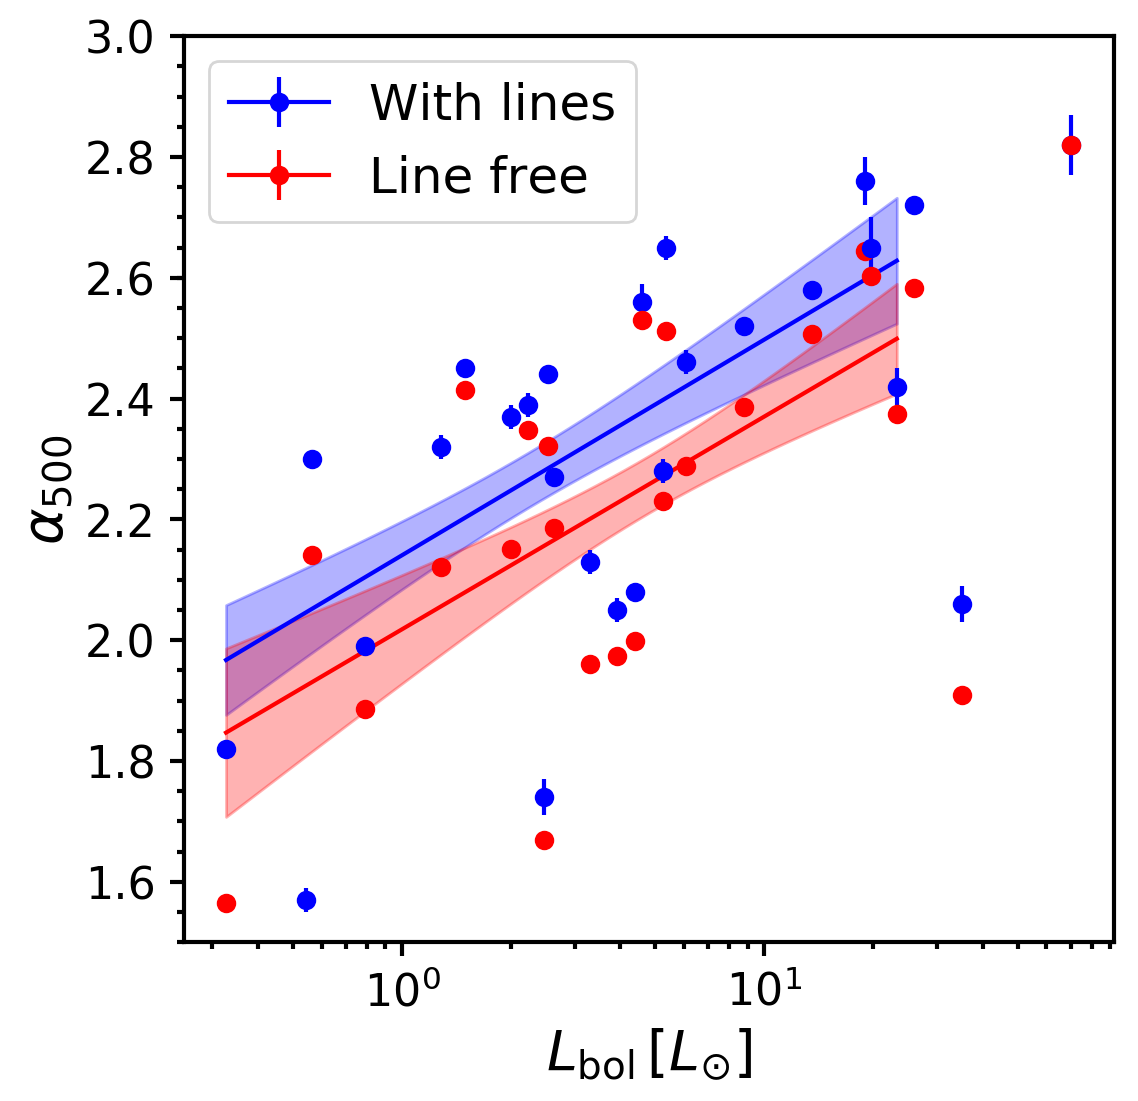

In [208]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

lsubmm_list = []

lbol = []
a500_fit = []
a500_linefree_fit = []
a500_fit_err = []
a500_linefree_fit_err = []
for o in obj_list:
    spec = ascii.read(archive_dir+o+'/spire/advanced_products/'+o+'_spire_corrected_continuum.txt')
    l = lsubmm(350, spec, dist['distance'][dist['object'] == o])
    lsubmm_list.append(l)

    # read in the alpha500 fitted with line-free SEDs
    a500_linefree = ascii.read('/Volumes/SD-Mac/research/cops-spire/spire_alpha/'+o+'_alpha_continuum.txt')
    
    if l_bol_list[obj_list.index(o)]/l <= 200.:
        class0 = ax.errorbar(l_bol_list[obj_list.index(o)], alpha500_list[obj_list.index(o)],
                    yerr=alpha500_err_list[obj_list.index(o)], marker='o', color='b', markersize=6)
        class0_free = ax.errorbar(l_bol_list[obj_list.index(o)], a500_linefree['500um'][0],
                                  yerr=a500_linefree['500um'][1], marker='o', color='r', markersize=6)
        
        lbol.append(l_bol_list[obj_list.index(o)])
        a500_fit.append(alpha500_list[obj_list.index(o)])
        a500_fit_err.append(alpha500_err_list[obj_list.index(o)])
        a500_linefree_fit.append(a500_linefree['500um'][0])
        a500_linefree_fit_err.append(a500_linefree['500um'][1])
        
    else:
        class1 = ax.errorbar(l_bol_list[obj_list.index(o)], alpha500_list[obj_list.index(o)],
                    yerr=alpha500_err_list[obj_list.index(o)], marker='o', color='b', markersize=6)
        class1_free = ax.errorbar(l_bol_list[obj_list.index(o)], a500_linefree['500um'][0],
                                  yerr=a500_linefree['500um'][1], marker='o', color='r', markersize=6)

a500_lbol = np.polyfit(np.log10(lbol), a500_fit, deg=1, w=1/np.array(a500_fit_err), cov=True)
a500_lbol_linefree = np.polyfit(np.log10(lbol), a500_linefree_fit, deg=1, w=1/np.array(a500_linefree_fit_err), cov=True)

lbol = np.array(np.log10(lbol))

xfit = np.linspace(lbol.min(), lbol.max(), 50)
yfit =  a500_lbol[0][0]*xfit+a500_lbol[0][1]
yfit_linefree = a500_lbol_linefree[0][0]*xfit+a500_lbol_linefree[0][1]
yerr = (a500_lbol[1][0,0]*xfit**2+2*a500_lbol[1][1,0]*xfit+a500_lbol[1][1,1])**0.5
yerr_linefree = (a500_lbol_linefree[1][0,0]*xfit**2+2*a500_lbol_linefree[1][1,0]*xfit+a500_lbol_linefree[1][1,1])**0.5

ax.plot(10**xfit, yfit, color='b')
ax.fill_between(10**xfit, yfit+yerr, yfit-yerr, color='b', alpha=0.3)

ax.plot(10**xfit, yfit_linefree, color='r')
ax.fill_between(10**xfit, yfit_linefree+yerr_linefree, yfit_linefree-yerr_linefree, color='r', alpha=0.3)

ax.set_ylim([1.5, 3.0])

ax.legend([class0, class0_free], ['With lines', 'Line free'], 
          fontsize=18, loc='best')
ax.set_xlabel(r'$L_{\rm bol}\,[L_{\odot}]$', fontsize=20)
ax.set_ylabel(r'$\alpha_{500}$', fontsize=20)
ax.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=5)
ax.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=2.5)
ax.set_xscale('log')

[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()

fig.savefig(plotdir+'/evolutionary/alpha500_linefree_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Fit the SPIRE spectra with a single blackbody

In [32]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import astropy.constants as const
c = const.c.cgs.value
h = const.h.cgs.value
k = const.k_B.cgs.value
pc = const.pc.cgs.value
AU = const.au.cgs.value
MS = const.M_sun.cgs.value
mh = const.m_p.cgs.value + const.m_e.cgs.value

Dust Models

In [34]:
# Weingartner & Draine
# dustfile = ascii.read('/Users/yaolun/Google Drive/dust_model/Weingartner_Draine/kext_albedo_WD_MW_5.5A_30_D03_nocomment.all',
#                       header_start=64, data_start=67)

# Ossenkopf & Hennings
# dustfile = ascii.read('/Users/yaolun/programs/misc/oh5_hyperion.txt', names=['nu', 'albedo','chi','g'])

# Use Neal's original version of OH5 dust
dustfile = np.genfromtxt('/Volumes/SD-Mac/Google Drive/dust_model/Dust_OH5_Evans_Shirley/sigma.oh5.ref', 
                          skip_header=2, skip_footer=1).T

BHR71

E(B-V) = 1.7790 +/-  0.1581 (S&F 2011) and	2.0686 +/-  0.1839 (SFD 1998)

if Rv = 5.5

Av = 9.78 & 11.38

$S_{\nu} = B_{\nu}(T_{dust}) (1-e^{-\tau_{\nu}})\Omega_{beam, \nu}$

In optically thin limit

$S_{\nu} = B_{\nu}(T_{dust})\tau_{\nu}\Omega_{beam, \nu}$

assume $\tau_{\nu} = N_{dust} \sigma_{d} Q_{ext}$

$\sigma_{d}$ is the geometric cross-section of dust grains, and $Q_{ext}$ is the dimensionless extinction efficiency

take $\sigma_{d} Q_{ext} = \sigma_{ext} = \sigma_{scat}+\sigma_{abs}$

then $S_{\nu} = B_{\nu}(T_{dust})\sigma_{ext}N_{dust}\Omega_{beam, \nu}$

The goal is to fit
$S_{\nu} \propto B_{\nu}(T_{dust})\nu^{\beta}$

In [66]:
def modbb_fitter(spec, fitted_size, fix_temp=None, verbose=True, pacs_size=31.8):    
    import numpy as np
    from scipy.optimize import curve_fit
    import astropy.constants as const
    from astropy.io import ascii
    from scipy.interpolate import interp1d
    
    c = const.c.cgs.value

    def bbfunc(nu, tdust, beta, Nd):

        h = const.h.cgs.value
        c = const.c.cgs.value
        k = const.k_B.cgs.value
        
        bb = 2.*h*(nu)**3/c**2 / (np.exp(h*nu/k/tdust)-1)
        
        nu500 = c/500*1e4

        return bb * (nu/nu500)**beta * Nd * omegab_func(nu)*1e11
    
    def omegab_func(nu):
        omegab = np.empty_like(nu)
        
        omegab[c/nu*1e4 > 200] = np.pi*(fitted_size/2)**2/4.25e10 # based on Makiwa+2016
        omegab[c/nu*1e4 <= 200] = np.pi*(pacs_size/2)**2/4.25e10
        
        return omegab
    
    selector = (np.isnan(spec['Flux_Density(Jy)']) == 0)
    
    nu = c/spec['Wavelength(um)'][selector]*1e4
    
    if fix_temp != None:
        bounds = ([fix_temp, 0, 0], [fix_temp+1, np.inf, np.inf])
        t0 = fix_temp
    else:
        bounds = (-np.inf, np.inf)
        t0 = 10.0
    
    popt, pcov = curve_fit(bbfunc, nu, spec['Flux_Density(Jy)'][selector], sigma=spec['Flux_Density(Jy)'][selector]*0.05,
                           p0=[t0, 1.8, 1e9], check_finite=True, bounds=bounds)
    if verbose:
        print(obj)
        print(popt[0], '+/-', pcov[0,0]**0.5)
        print(popt[1], '+/-', pcov[1,1]**0.5)
    
    return popt, pcov, bbfunc
    

RCrA-IRS7B
45.3564994537 +/- 0.948849974216
1.17612577972 +/- 0.013542894462
RCrA-IRS7C
63.8905908367 +/- 2.26344100524
1.12393029805 +/- 0.0151190360209
HH46
8.3136189453 +/- 0.124494307126
3.93511339517 +/- 0.0802249724701
L723-MM
6.3441981324 +/- 0.0990442242439
4.99300180272 +/- 0.112225607752
L1014
22.9202924417 +/- 0.25892093429
0.772164857929 +/- 0.0171744310099
L1157
5.26393546151 +/- 0.0789111054329
6.18399236103 +/- 0.130871727933
Ced110
26.9812668468 +/- 0.152494689639
1.03784562092 +/- 0.00705769578133
BHR71
8.3431727629 +/- 0.131332163729
4.05971356969 +/- 0.0841575240846
IRAS03245
7.88636340262 +/- 0.127316740835
4.22939356668 +/- 0.0917288696536
L1551-IRS5
7.61563151273 +/- 0.124230637181
4.60902128241 +/- 0.0965864689399
L1455-IRS3
15.136183424 +/- 0.197343970023
0.910192308113 +/- 0.0330993556463
B1-a
26.3056711179 +/- 0.316357393599
0.359426492286 +/- 0.0153080871988
B1-c
6.86436069601 +/- 0.102945975809
4.37225639464 +/- 0.0989130066095
IRAS03301
14.6985134699 +/- 0.

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

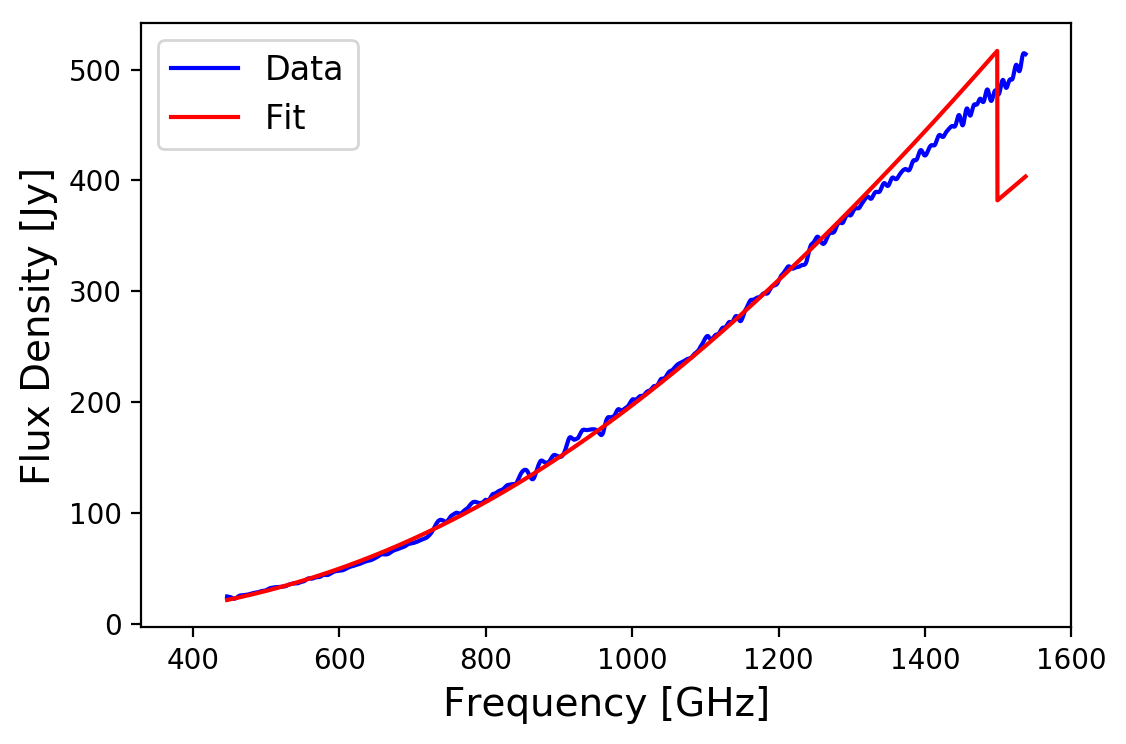

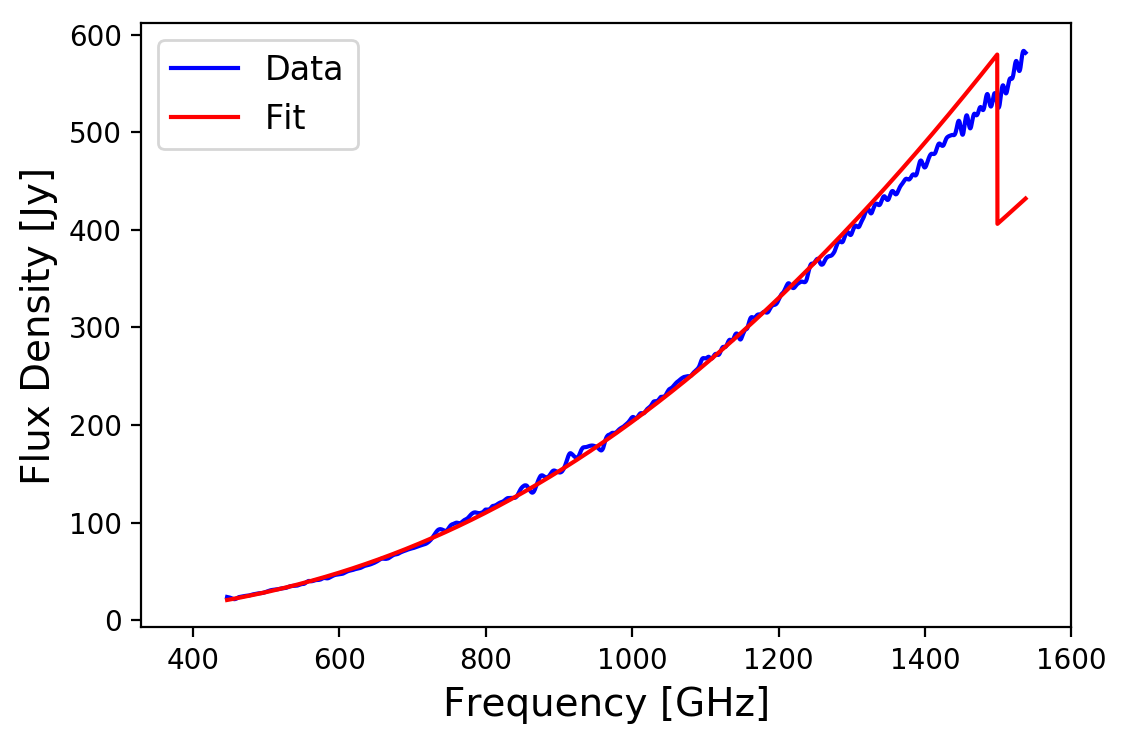

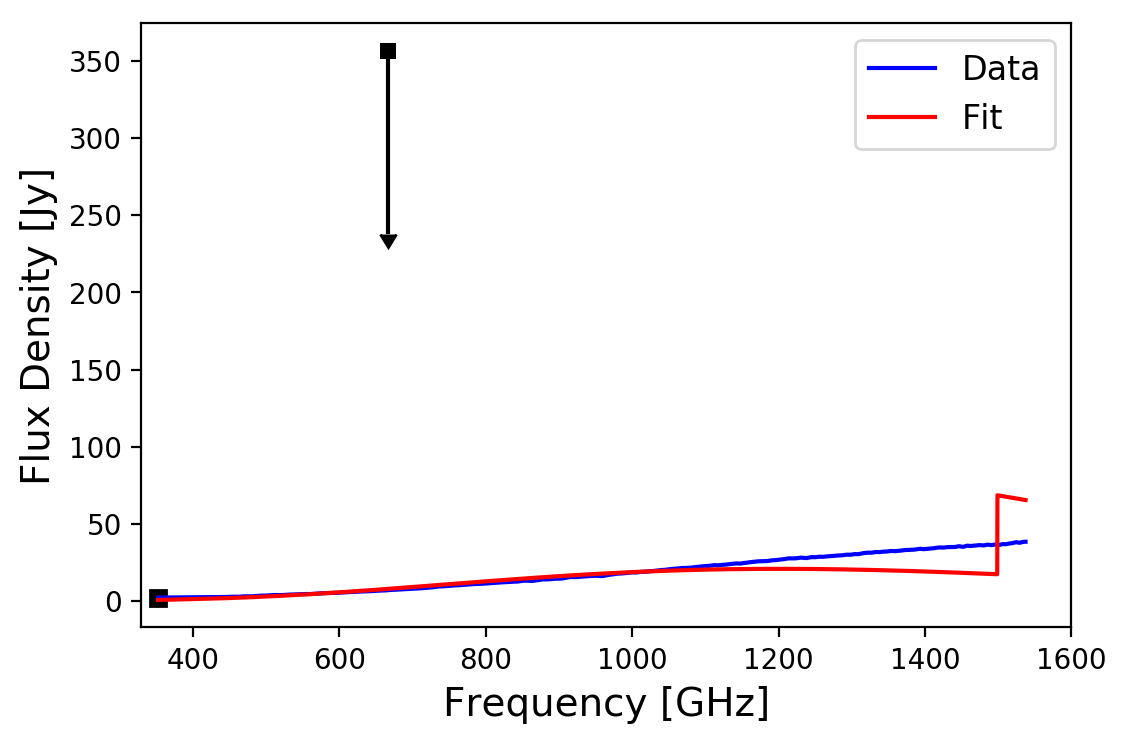

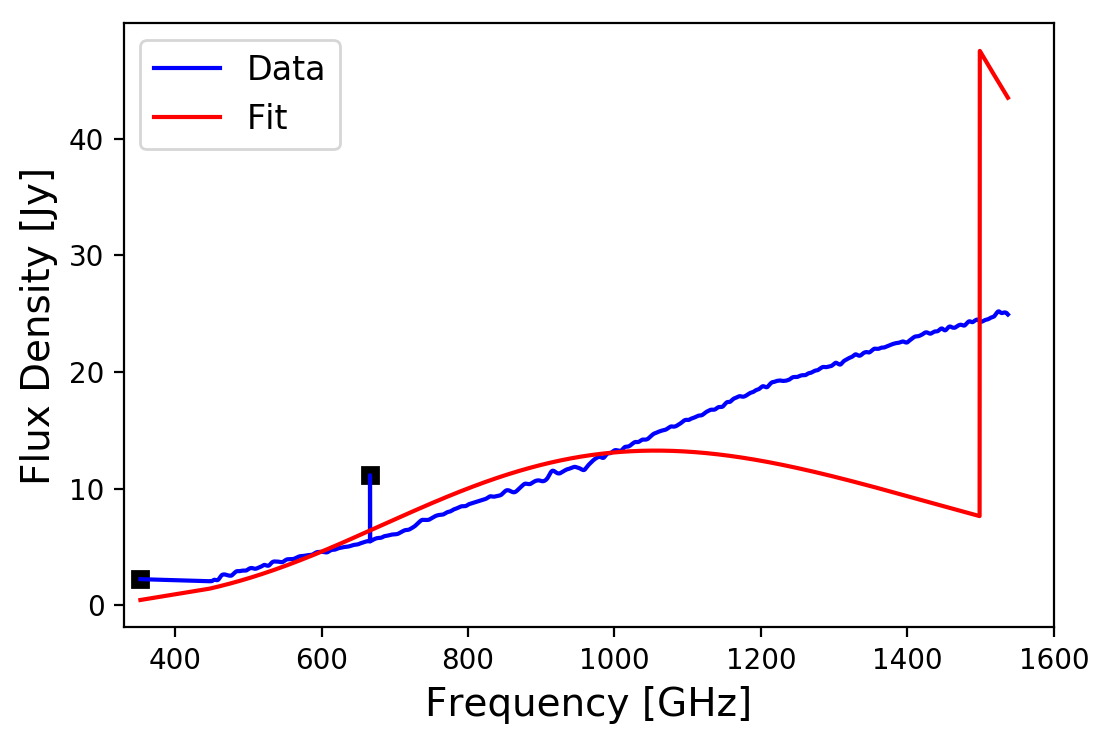

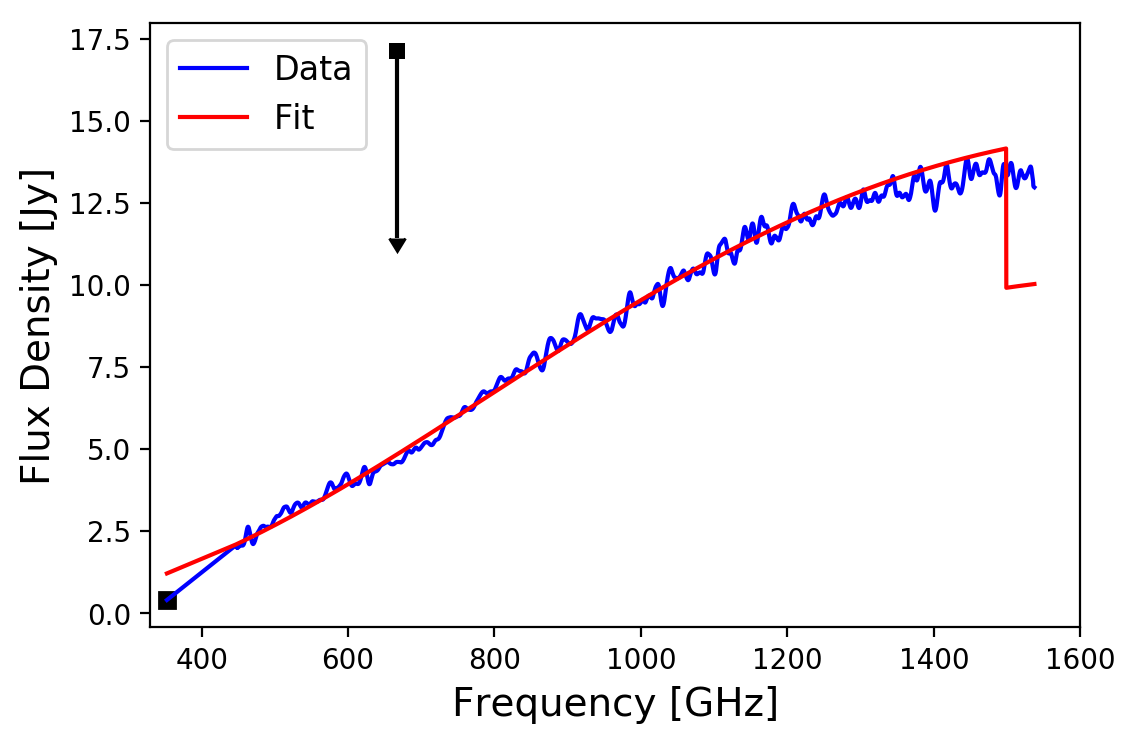

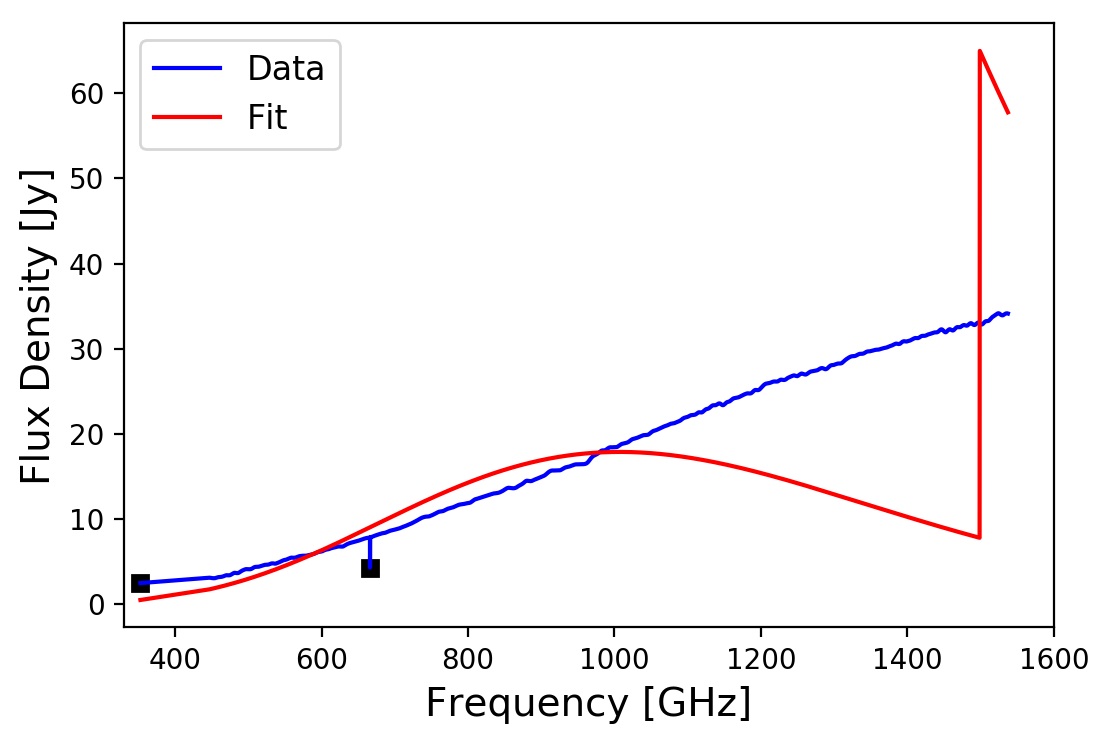

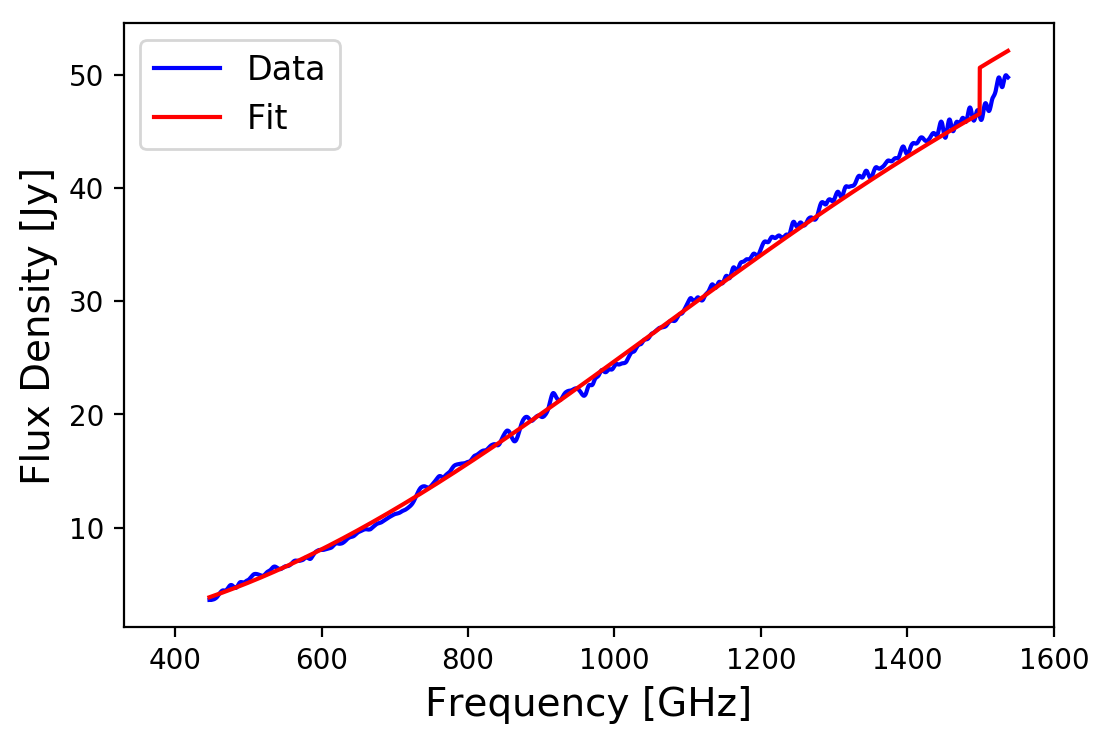

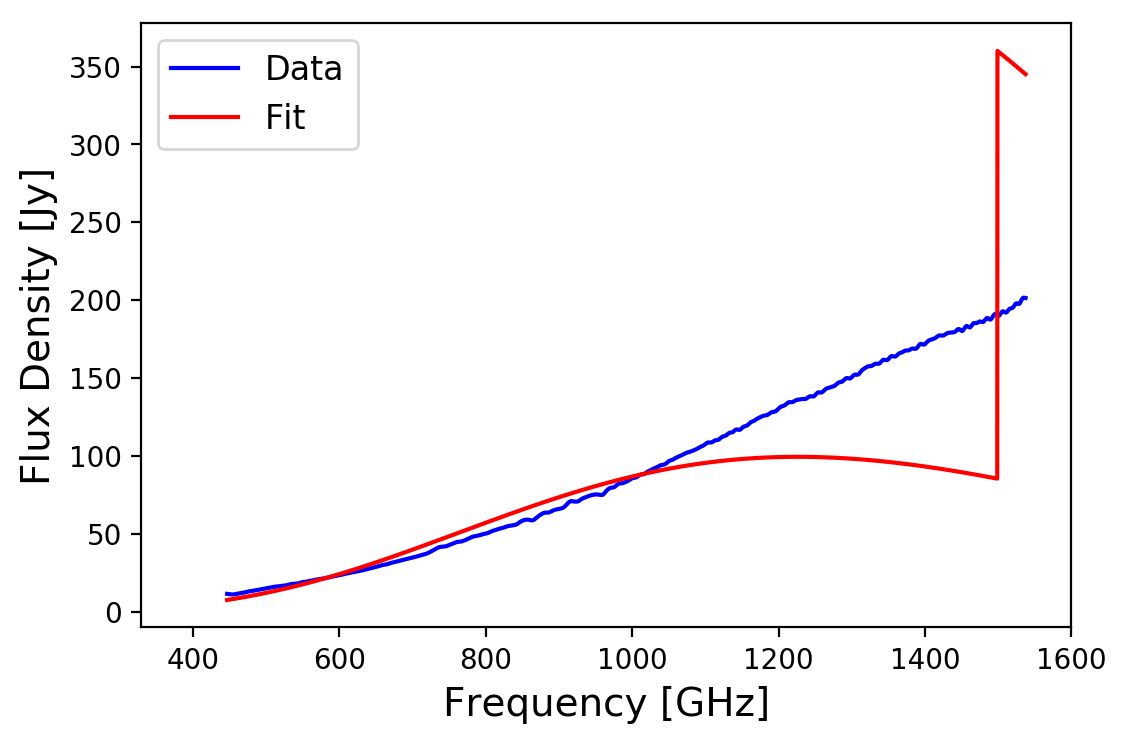

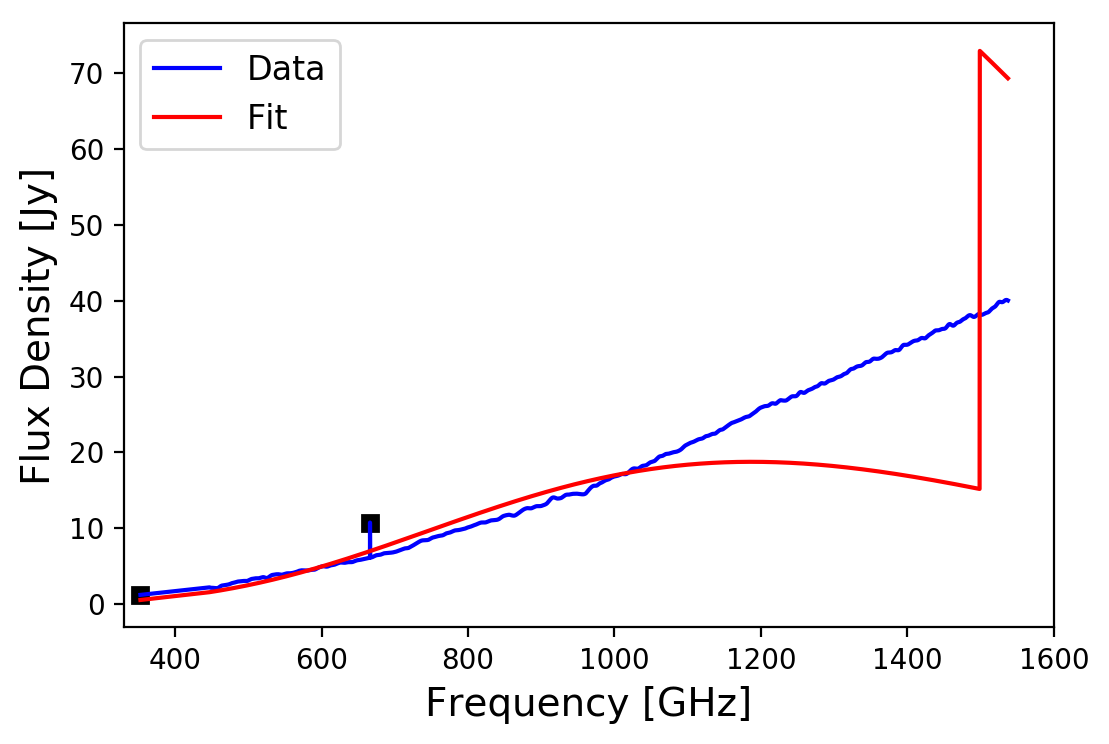

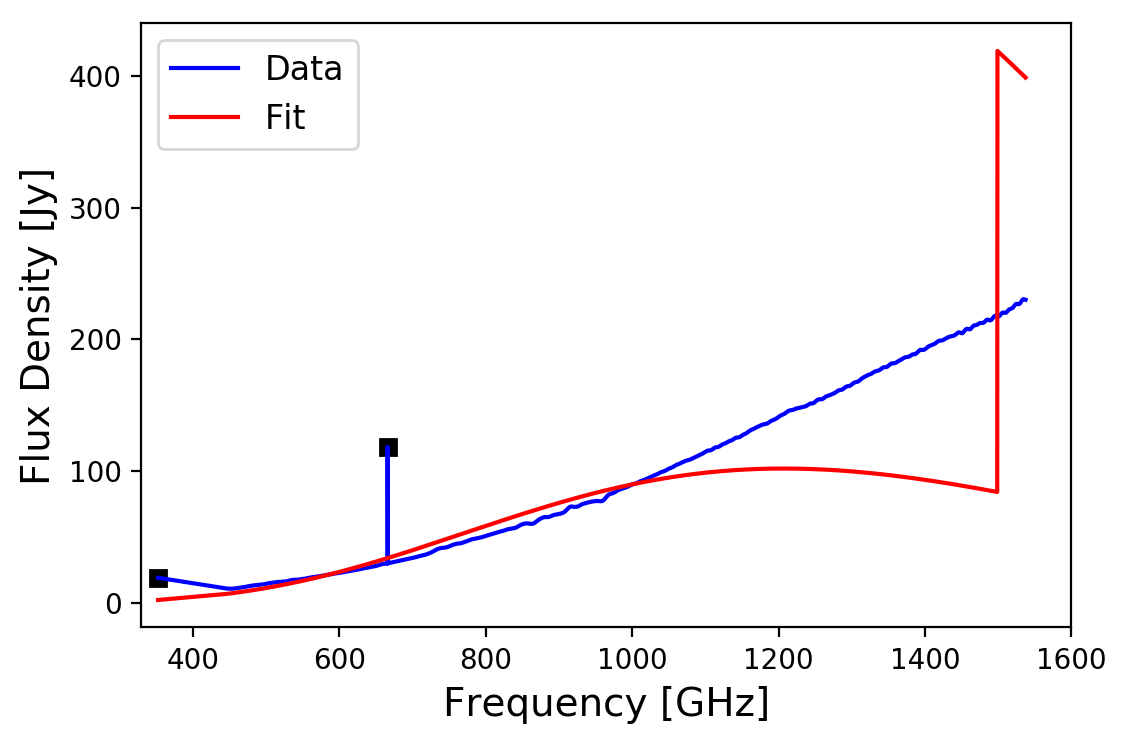

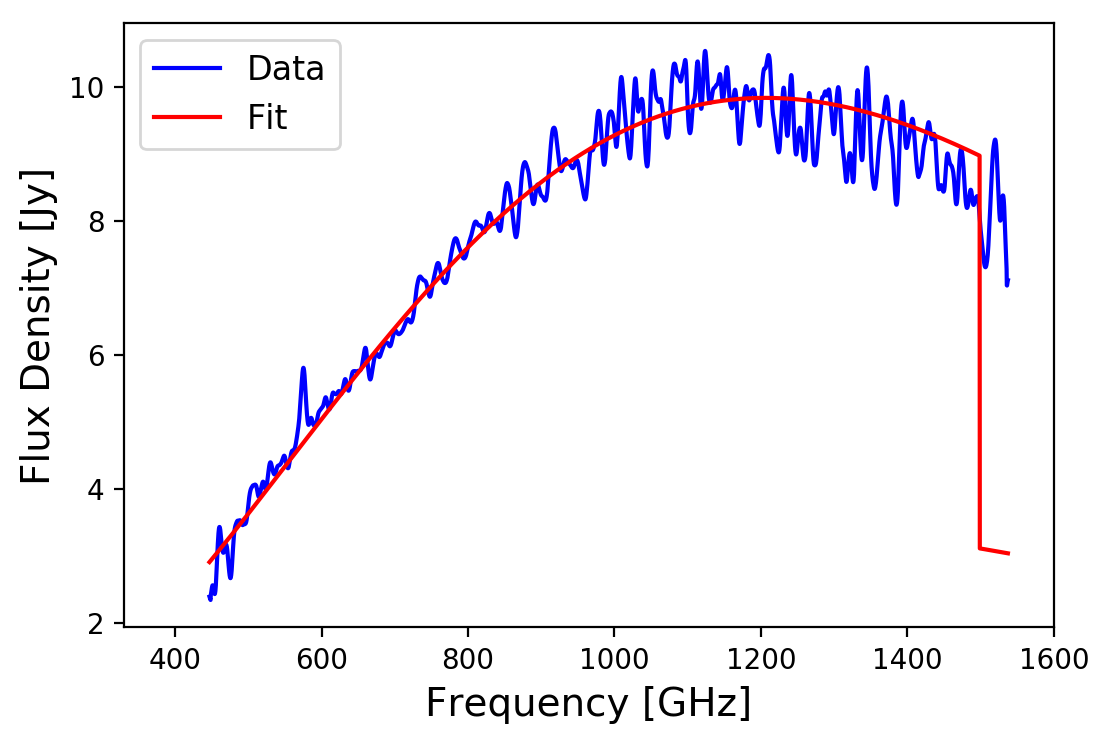

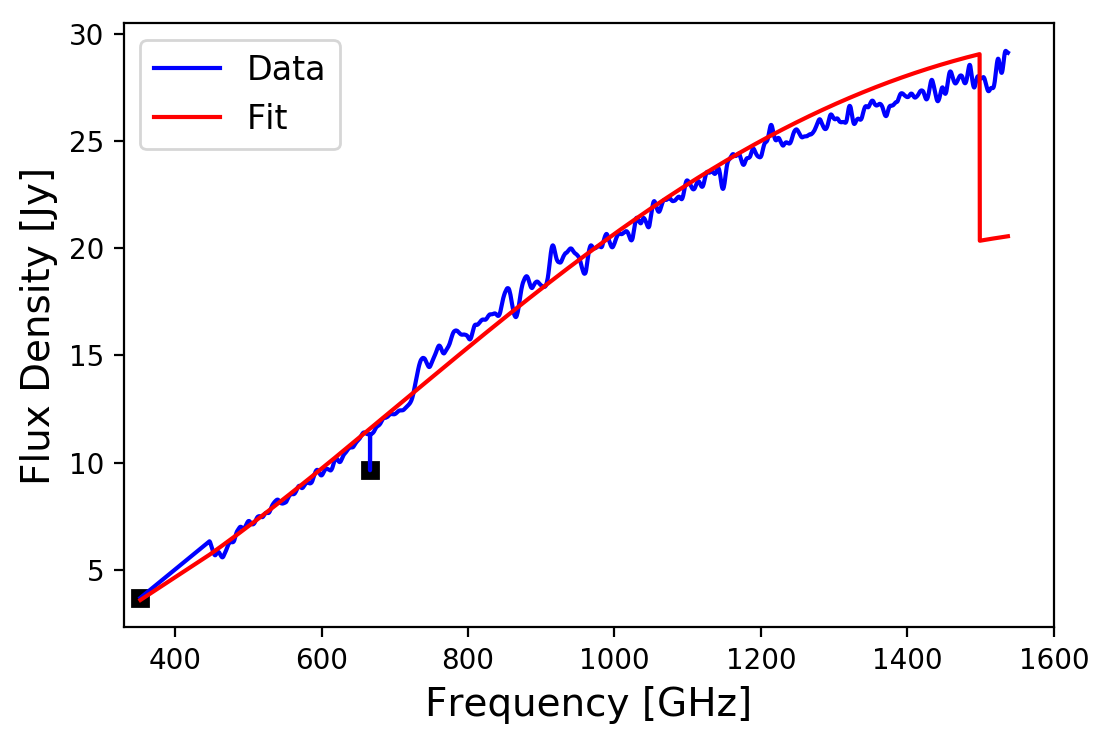

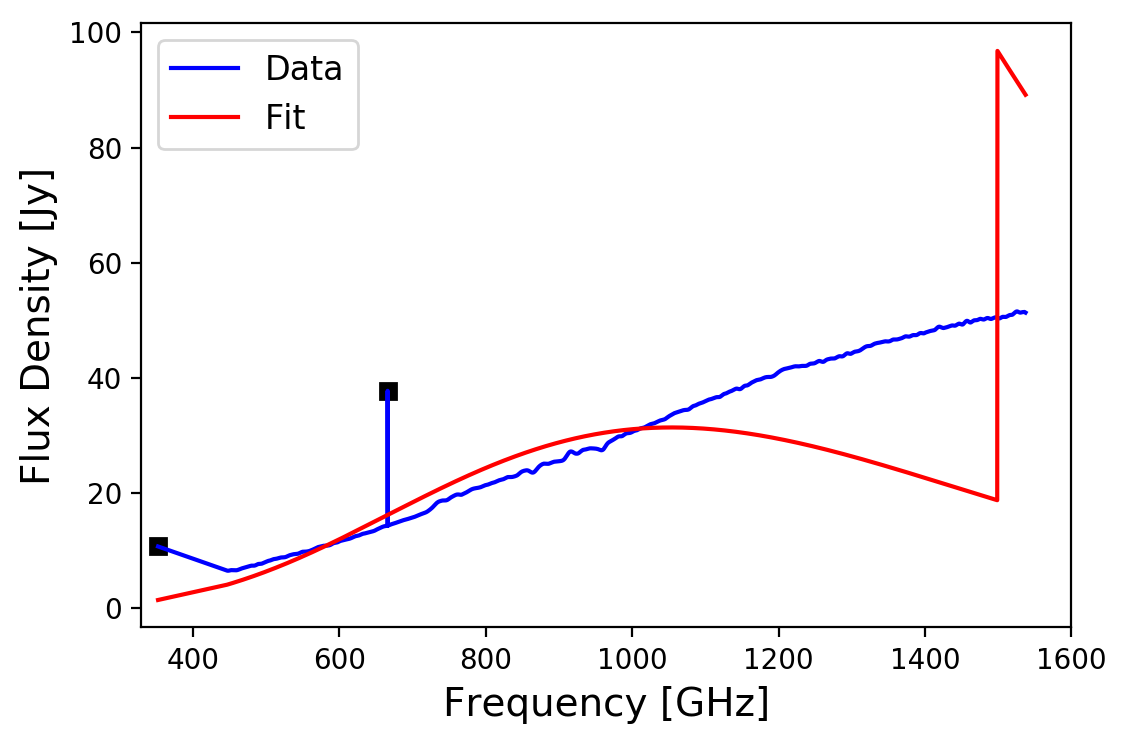

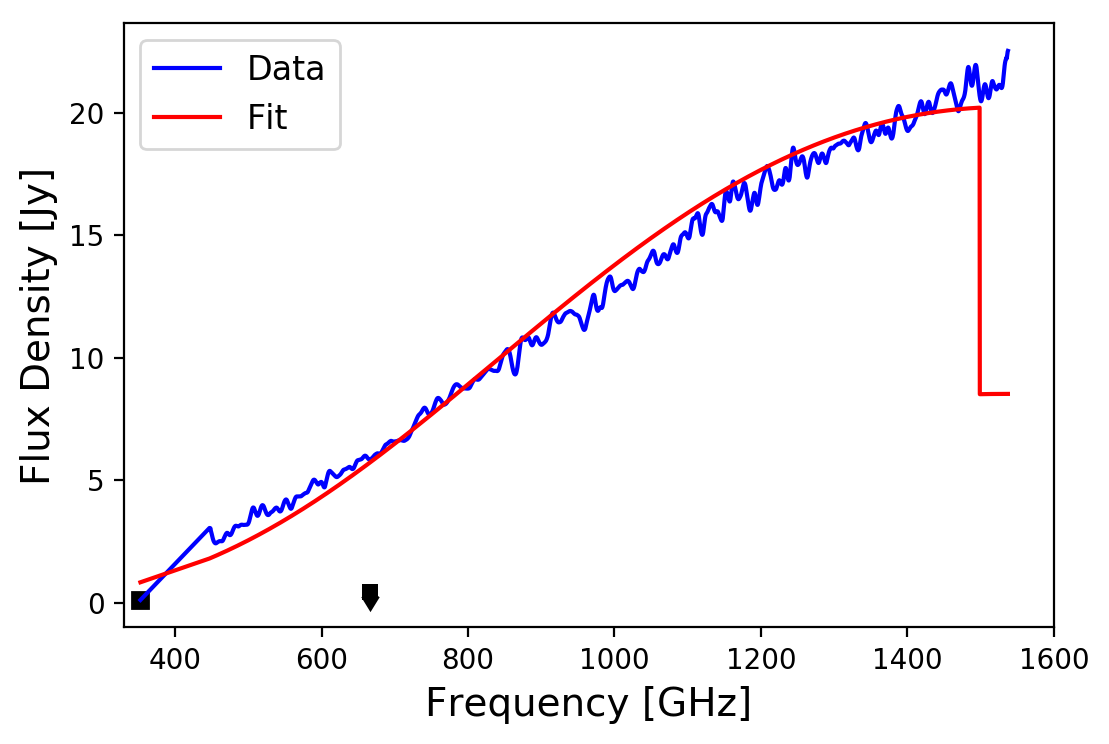

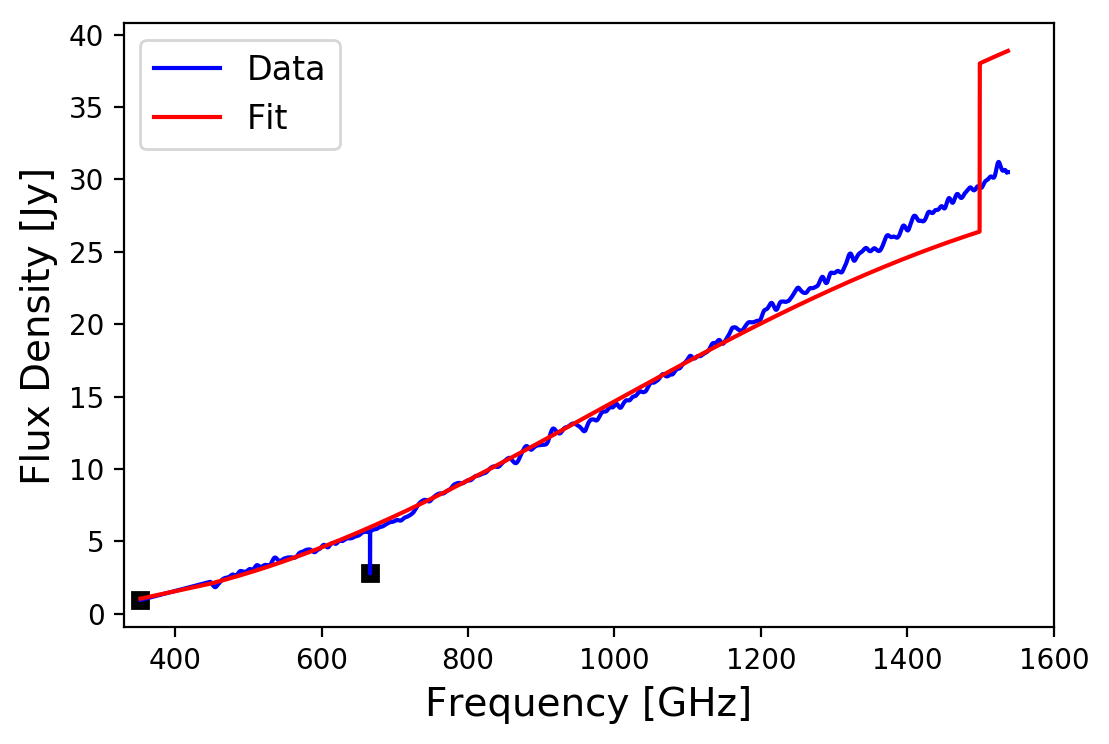

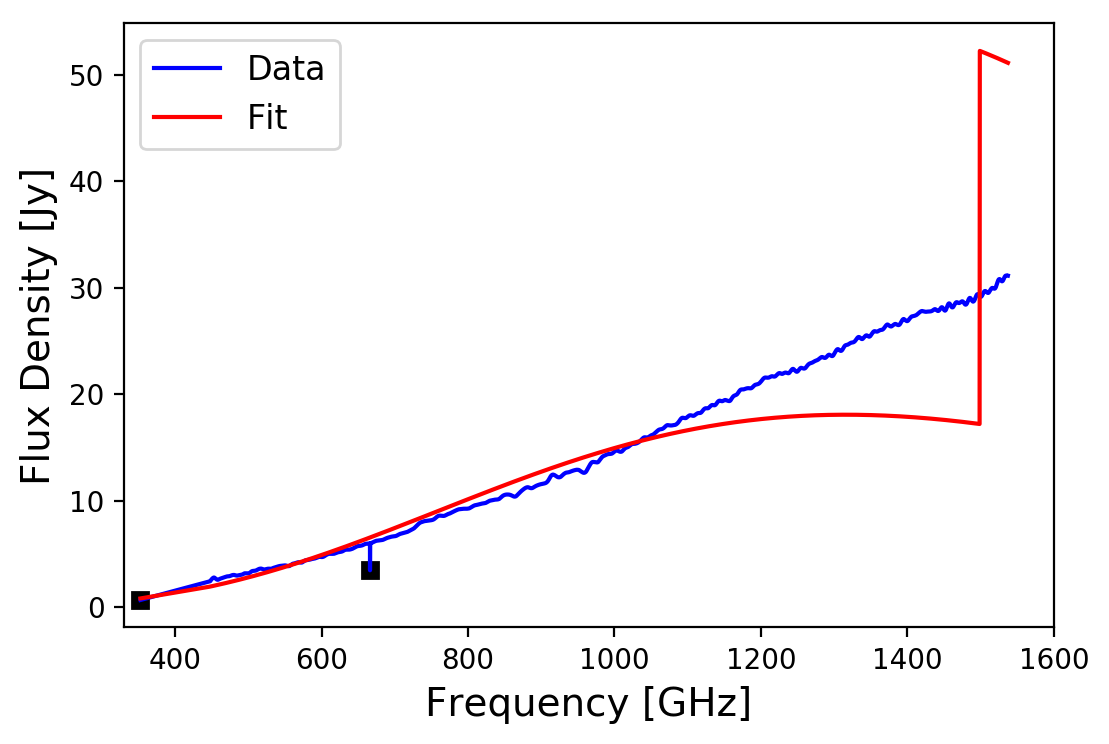

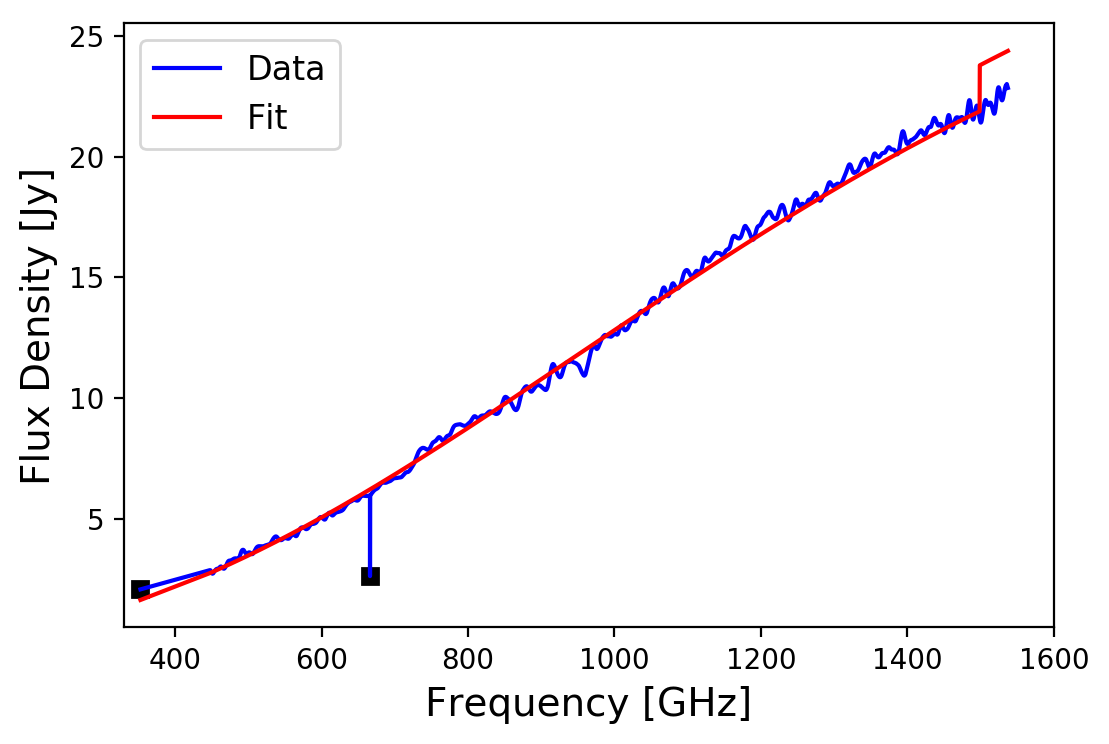

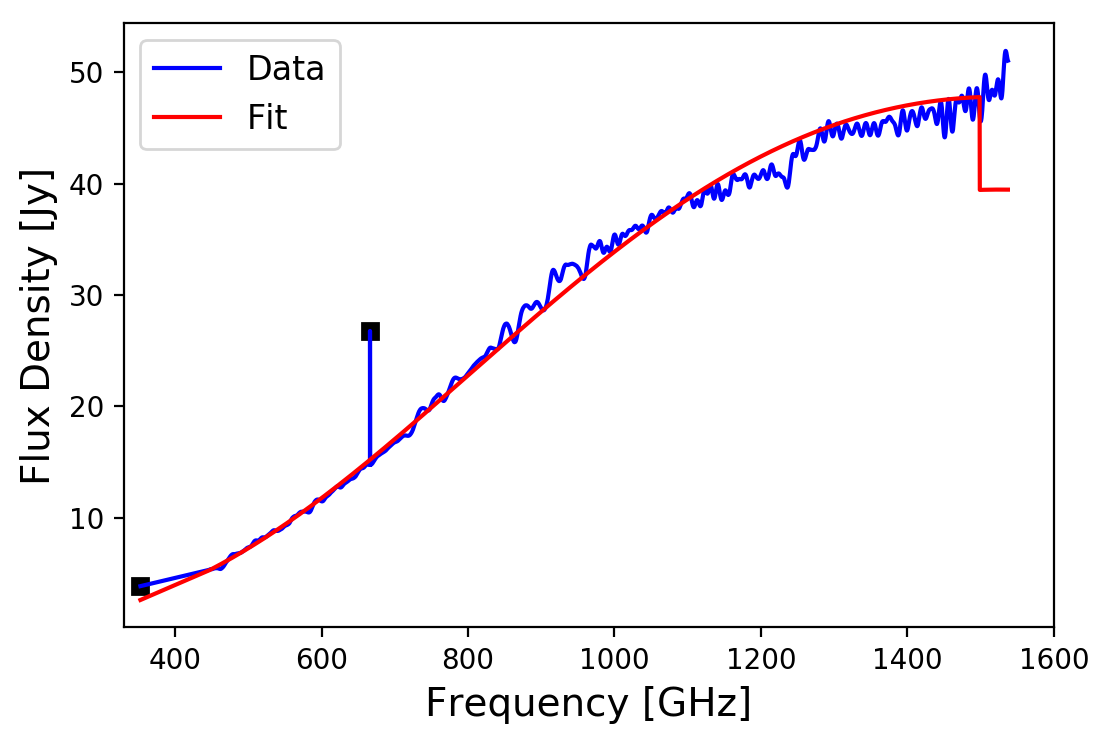

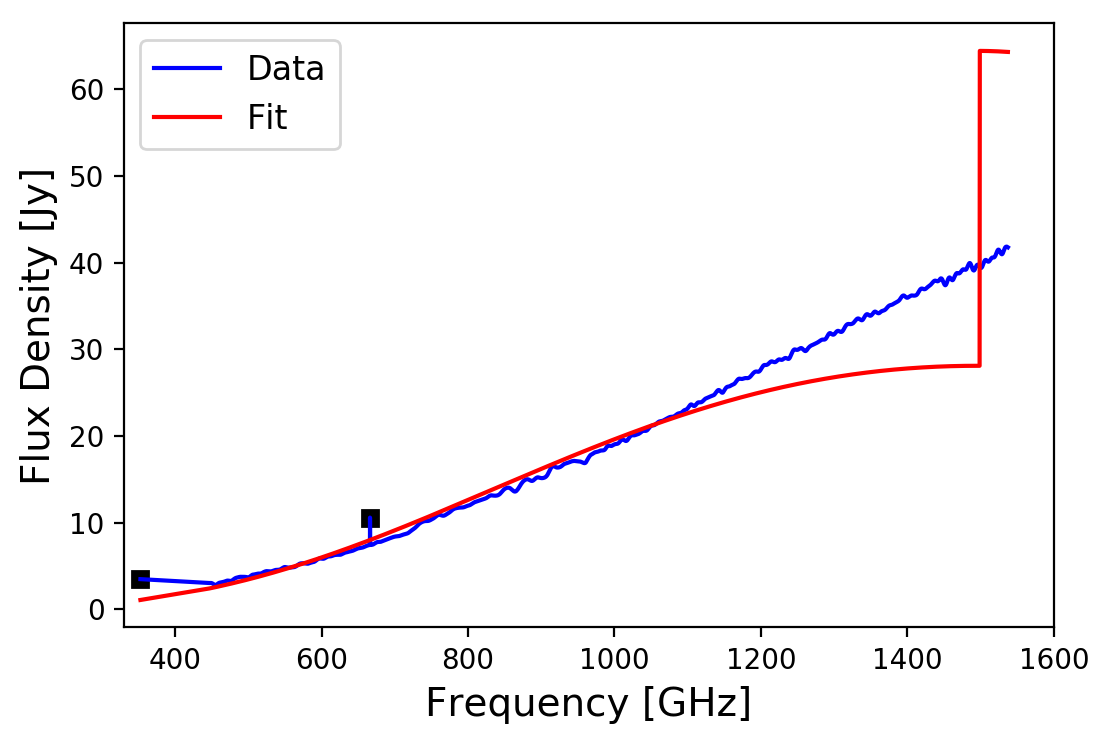

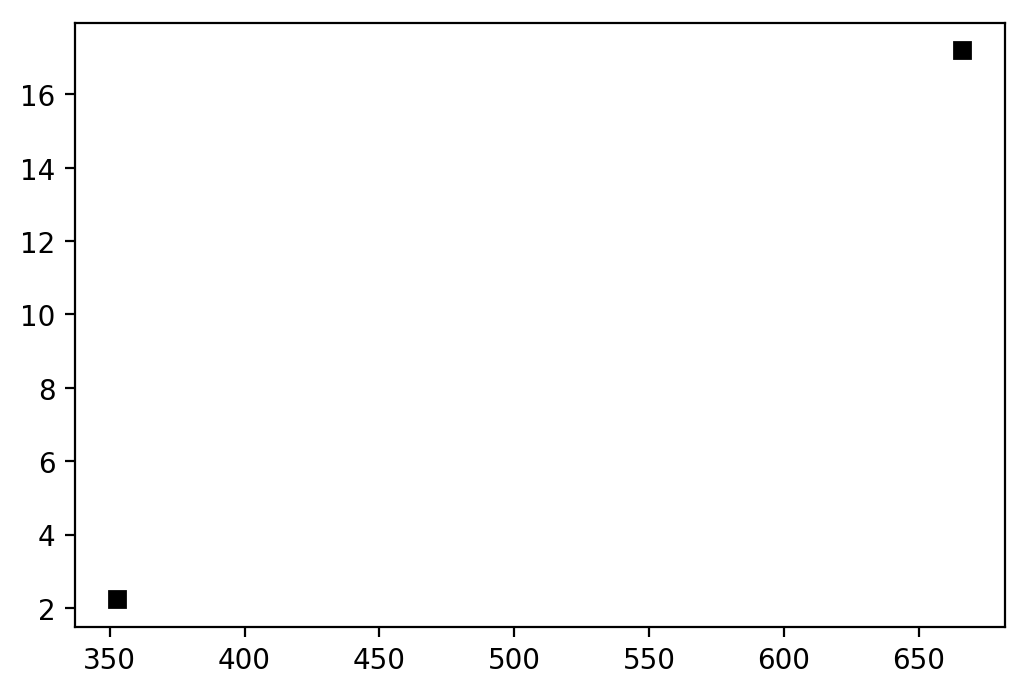

In [71]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import glob
import numpy as np
import astropy.constants as const
from fuzzywuzzy import fuzz, process
c = const.c.cgs.value

# getting SCUBA data
scuba = ascii.read('/Volumes/SD-Mac/Dropbox/real_cops-spire/SCUBA measurements of cops sources.txt',
                   fill_values=[('na', '0', 'F450(Jy)', 'F850(Jy)')])

foo = open('/Volumes/SD-Mac/research/cops-spire/greybbfit/results.txt', 'w')
foo.write('{:<10s}  {:<14s}  {:<14s}  {:<14s}  {:<14s}\n'.format('Object', 'Tdust', 'unc_Tdust', 'beta', 'unc_beta'))

for obj in obj_list:
    
#     if obj != 'L1014': continue
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    spec = ascii.read(archive_dir+obj+'/spire/advanced_products/'+obj+'_spire_corrected_continuum.txt')
    
    fitted_size = ascii.read(glob.glob(archive_dir+obj+'/spire/data/*meta*')[0], data_start=4)['size'].data[0]

    # insert SCUBA data if applicable
    # first fuzzy match the source name
    match = process.extractOne(obj, scuba['Source'])
    if match[1] < 90:
        print(match)
    else:
        # check if there is data for the object
        # 450 um
        if (scuba['F450(Jy)'][scuba['Source'] == match[0]].mask == False):
            if (scuba['F450(Jy)'][scuba['Source'] == match[0]] >= 0):
                spec.add_row([450.0, scuba['F450(Jy)'][scuba['Source'] == match[0]].data])
                ax.plot(c/450*1e4/1e9, spec['Flux_Density(Jy)'][spec['Wavelength(um)'] == 450], 'ks')
            else:
                ax.errorbar(c/450*1e4/1e9, abs(scuba['F450(Jy)'][scuba['Source'] == match[0]]),
                            yerr=-scuba['F450(Jy)'][scuba['Source'] == match[0]]/3,
                            uplims=True, fmt='s', mfc='k', markeredgewidth=1,
                            color='k', mec='None')
            
        # 850 um
        if (scuba['F850(Jy)'][scuba['Source'] == match[0]].mask == False):
            if (scuba['F850(Jy)'][scuba['Source'] == match[0]] >= 0):
                spec.add_row([850.0, scuba['F850(Jy)'][scuba['Source'] == match[0]].data])
                ax.plot(c/850*1e4/1e9, spec['Flux_Density(Jy)'][spec['Wavelength(um)'] == 850], 'ks')
            else:
                ax.errorbar(c/850*1e4/1e9, abs(scuba['F850(Jy)'][scuba['Source'] == match[0]]),
                                yerr=-scuba['F850(Jy)'][scuba['Source'] == match[0]]/3,
                                uplims=True, fmt='s', mfc='k', markeredgewidth=1,
                                color='k', mec='None')
    
    sorter = np.argsort(spec['Wavelength(um)'])
    spec = spec[sorter]
    
    popt, pcov, bbfunc = modbb_fitter(spec, fitted_size)

    foo.write('{:<10s}  {:<14e}  {:<14e}  {:<14e}  {:<14e}\n'.format(obj, popt[0], pcov[0,0]**0.5, popt[1], pcov[1,1]**0.5))


    data, = ax.plot(c/spec['Wavelength(um)']*1e4/1e9, spec['Flux_Density(Jy)'], 'b-')
#     ax.plot(c/spec['Wavelength(um)']*1e4, bbfunc(c/spec['Wavelength(um)']*1e4, 18, 1.8, 1e9))
    fit, = ax.plot(c/spec['Wavelength(um)']*1e4/1e9, bbfunc(c/spec['Wavelength(um)']*1e4, *popt), 'r-')
    
    ax.legend([data, fit], ['Data', 'Fit'], loc='best', fontsize=12)
#     ax.set_xlabel('Wavelength [$\mu$m]', fontsize=18)
    ax.set_xlabel('Frequency [GHz]', fontsize=14)
    ax.set_ylabel('Flux Density [Jy]', fontsize=14)
    ax.set_xlim([330,1600])
    
    fig.savefig('/Volumes/SD-Mac/research/cops-spire/greybbfit/'+obj+'_fitting.pdf', format='pdf', dpi=300, bbox_inches='tight')
    
foo.close()

### Fitting with the photometry

/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in power
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: R

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

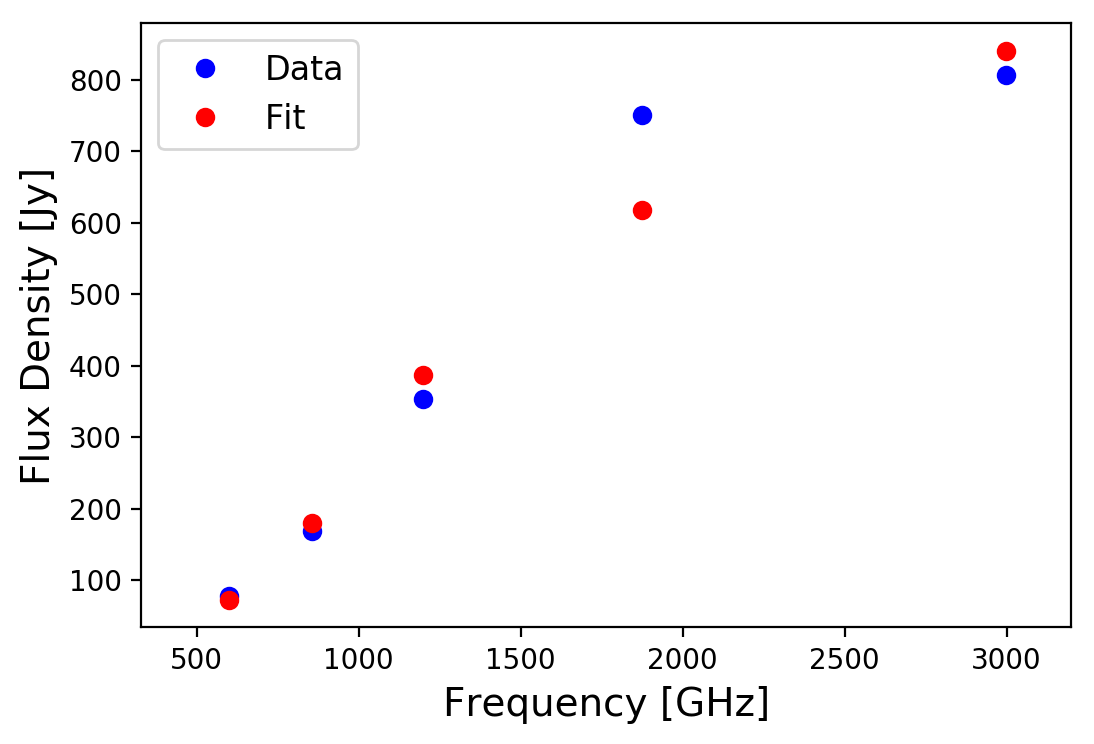

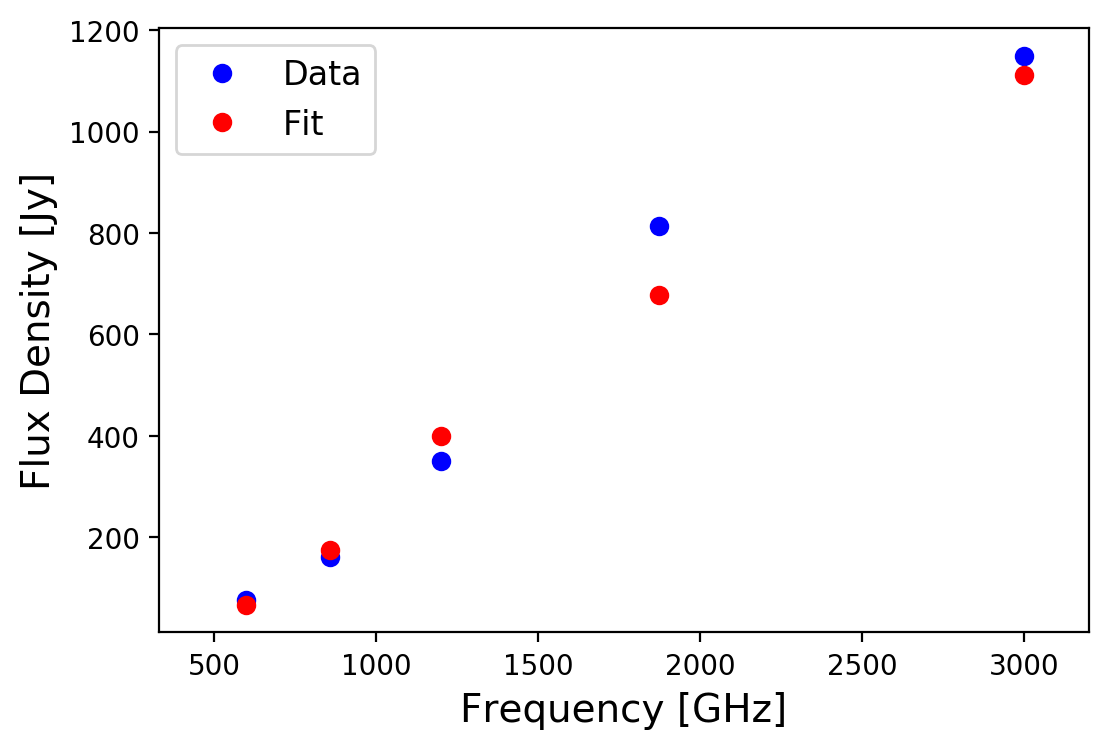

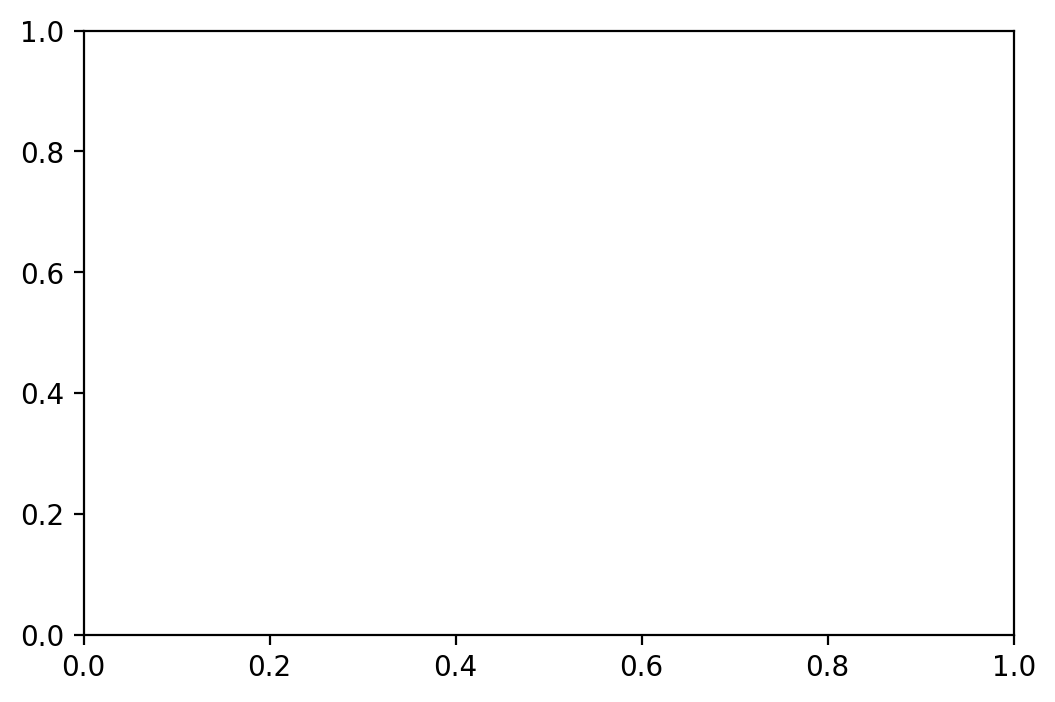

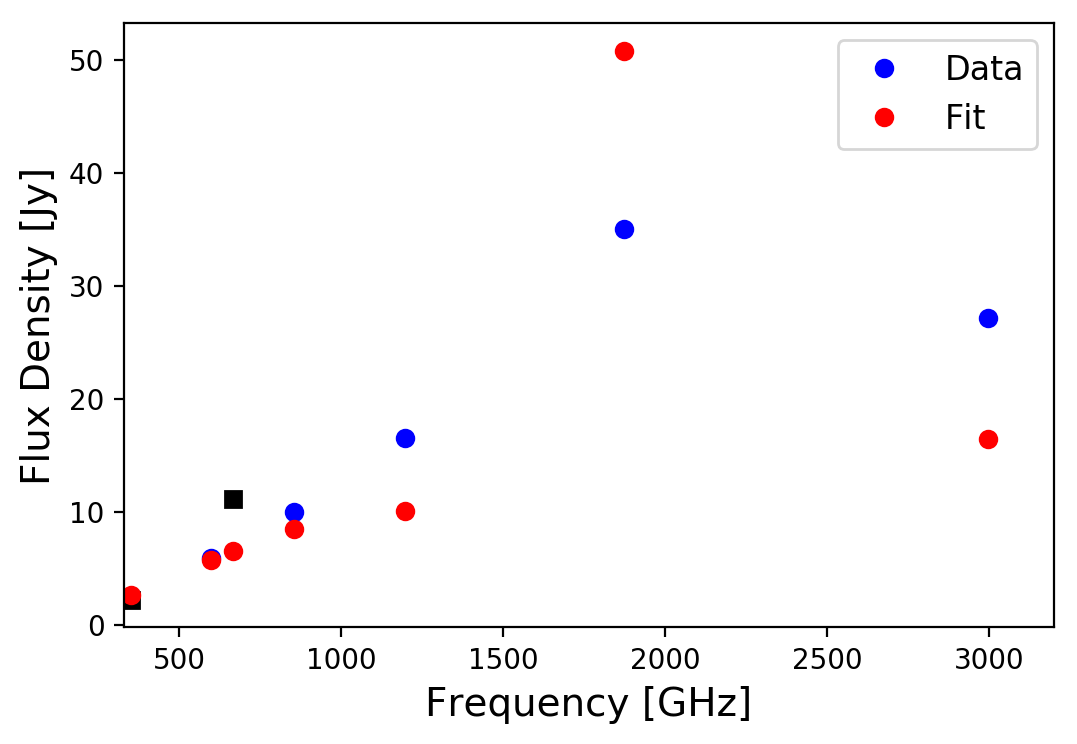

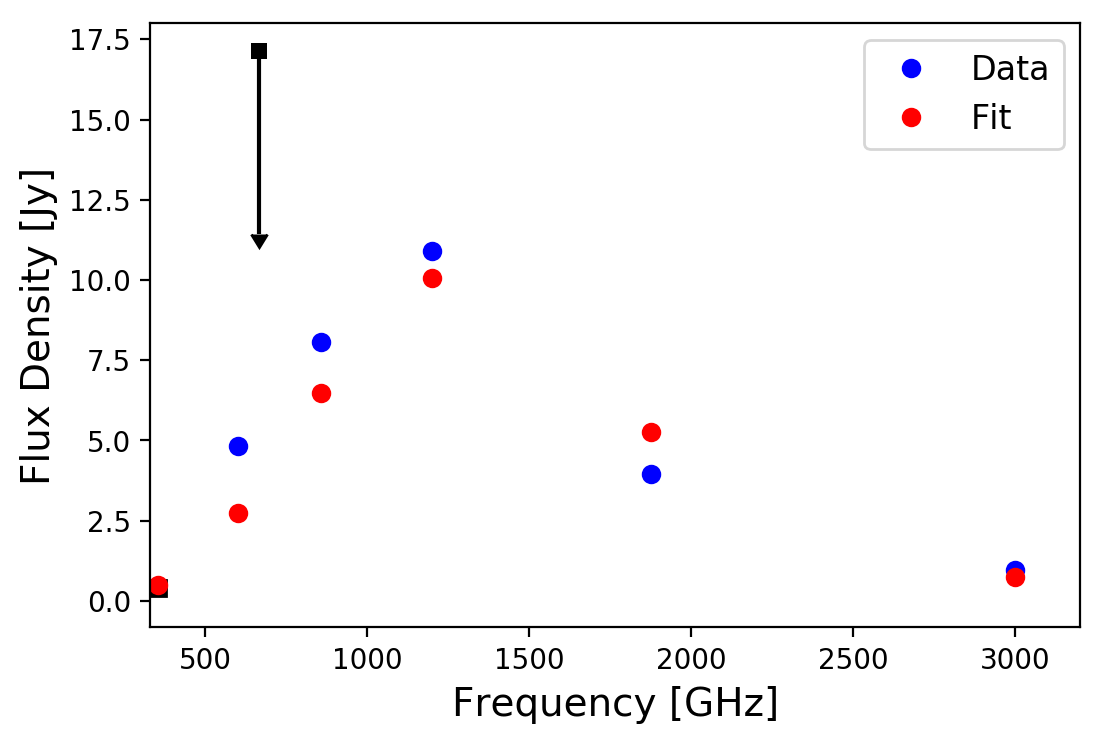

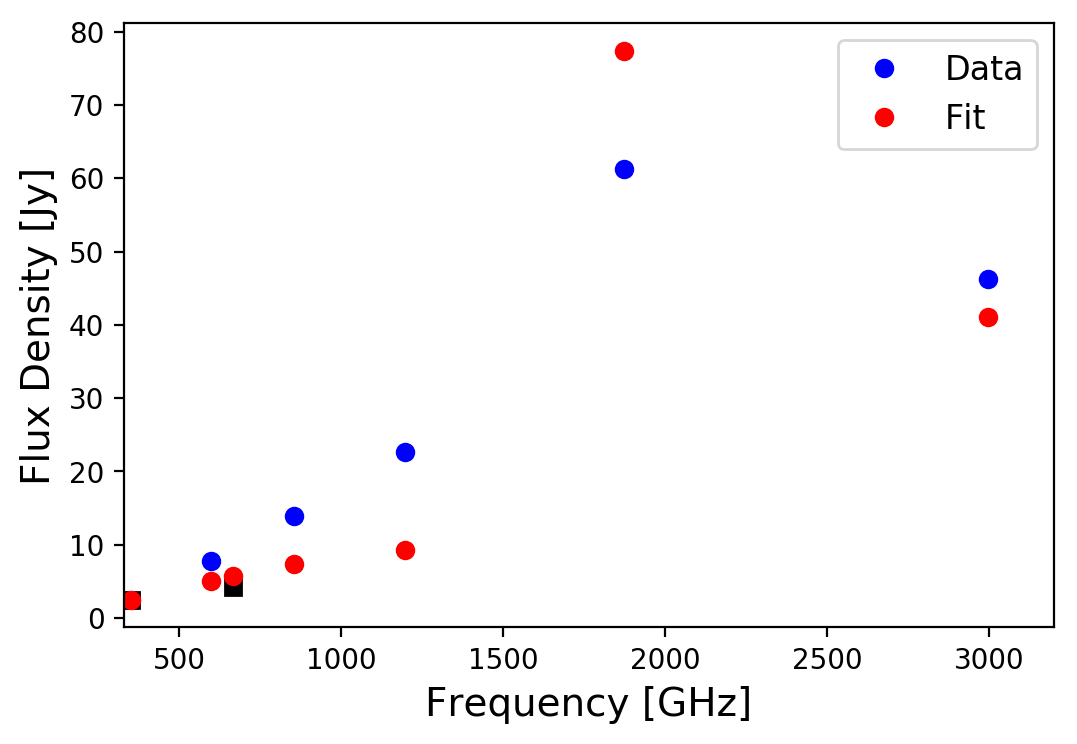

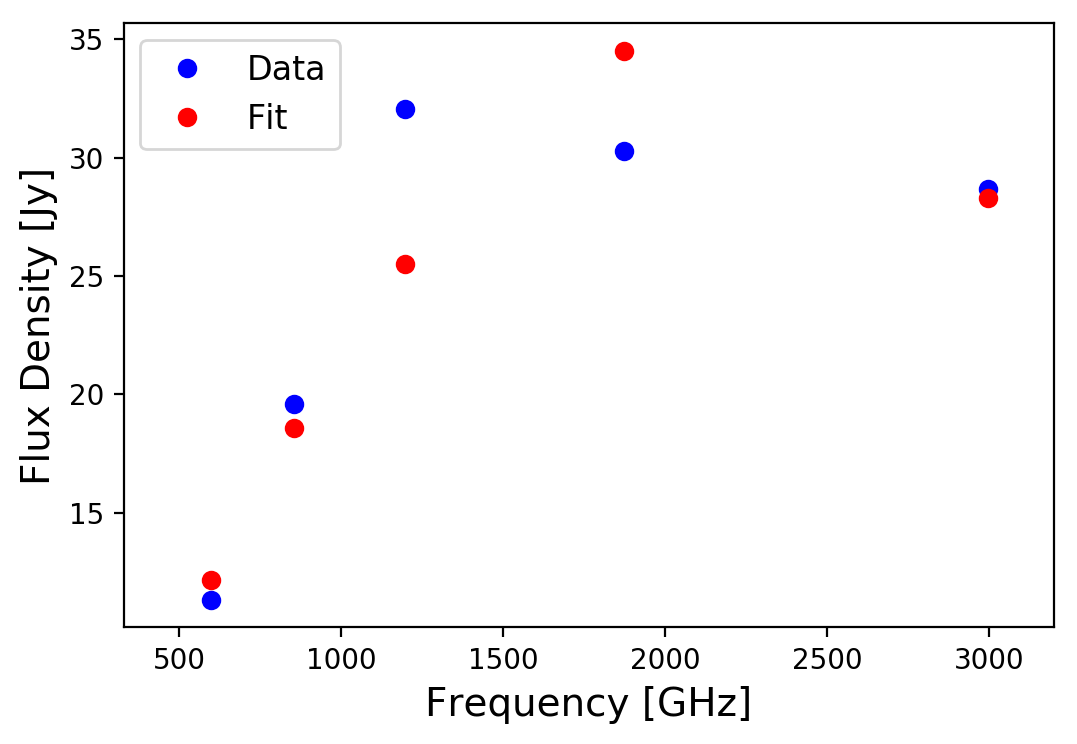

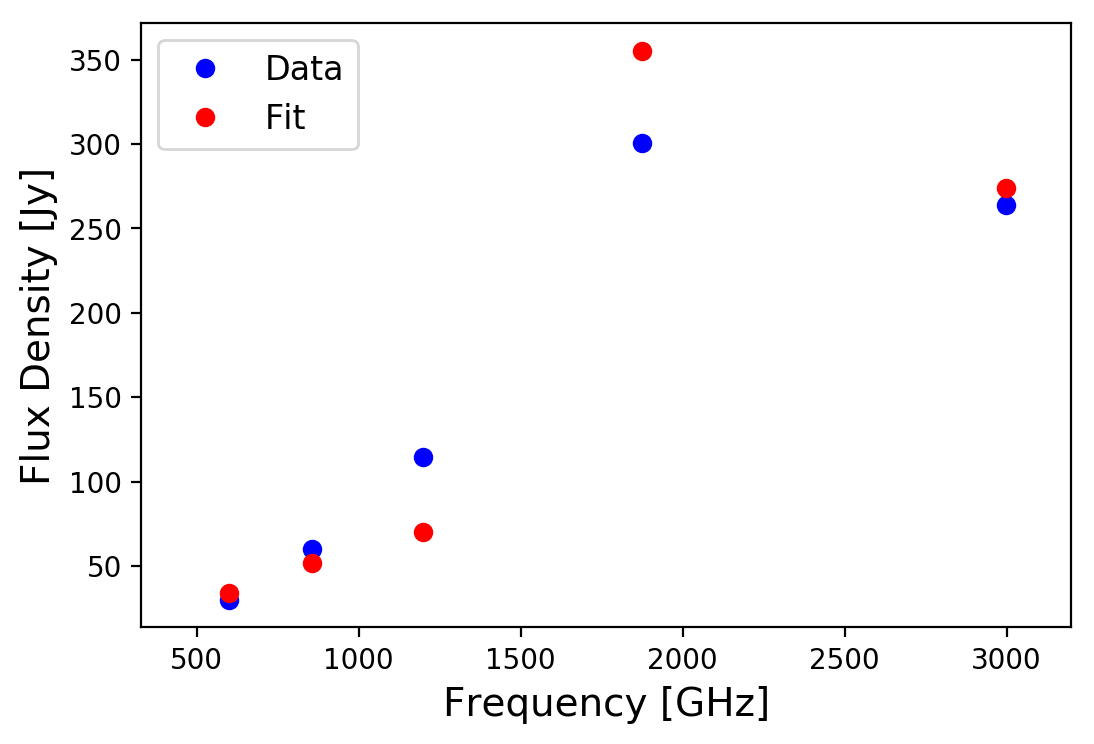

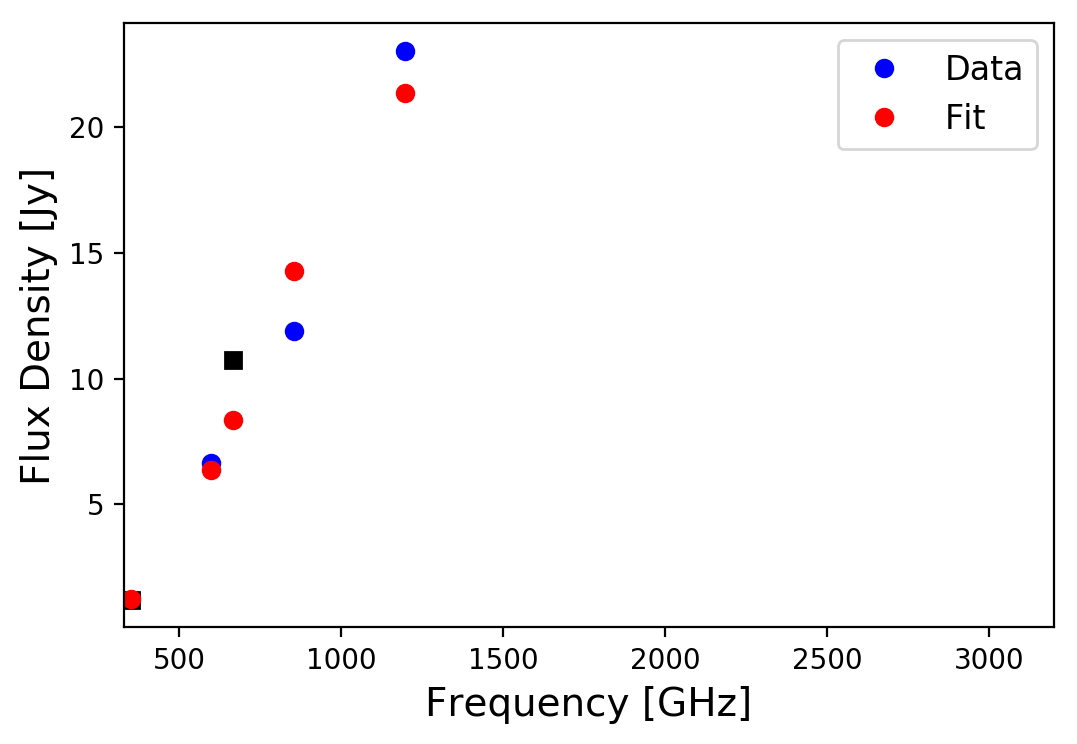

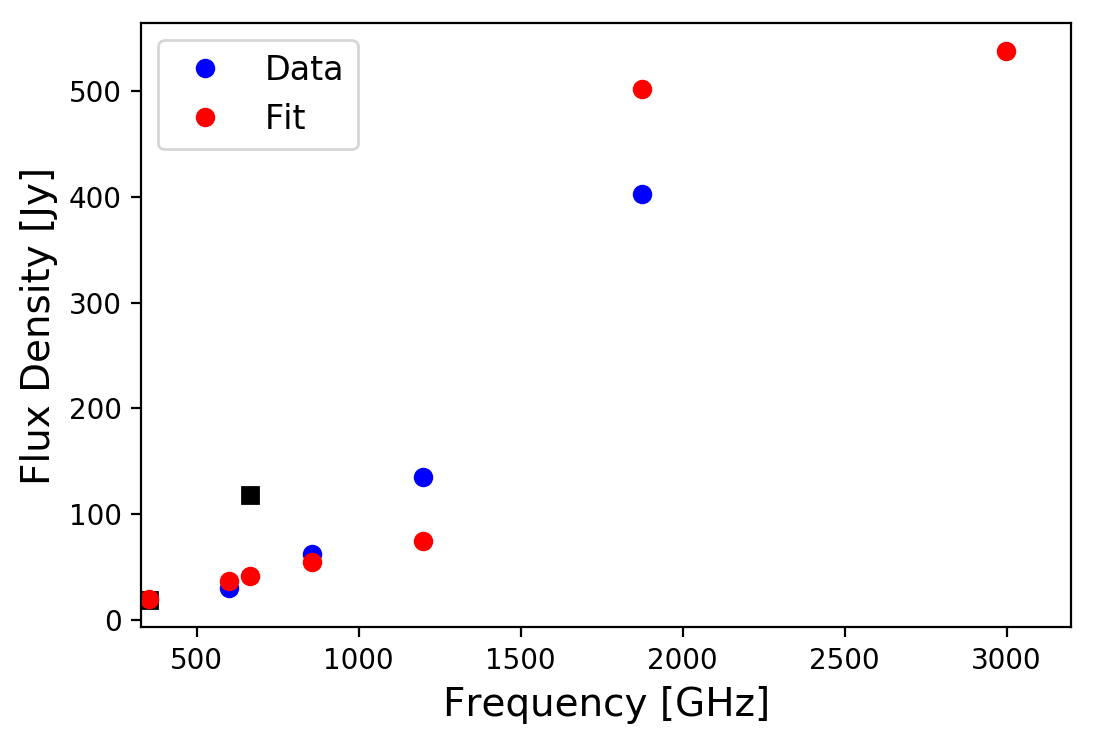

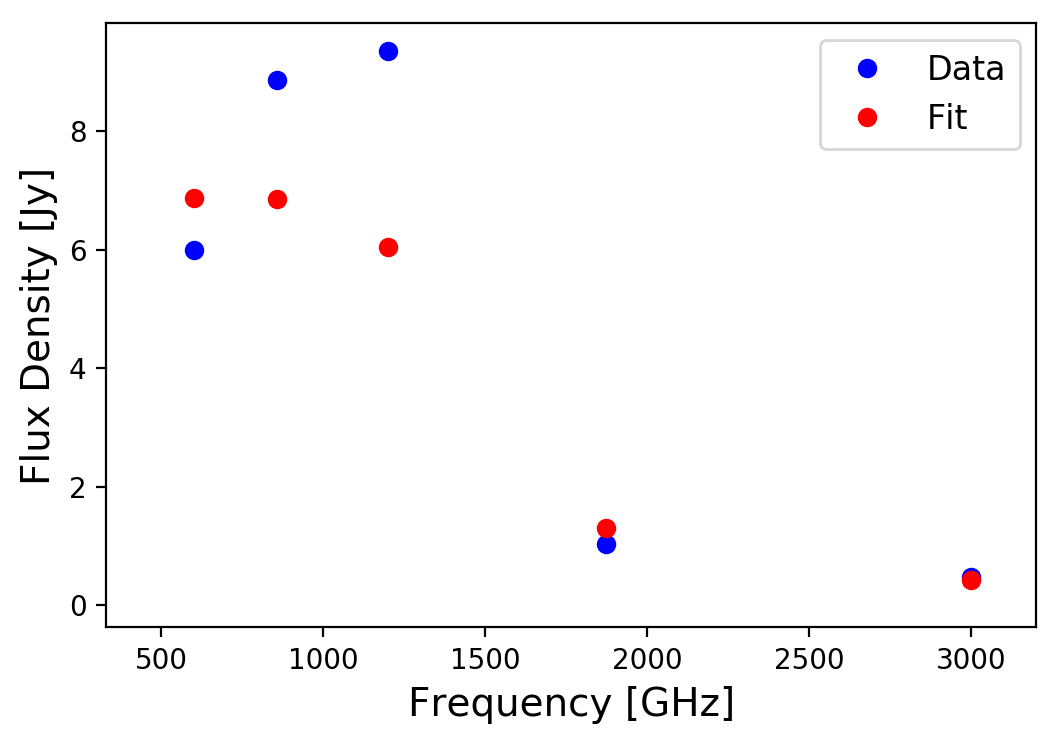

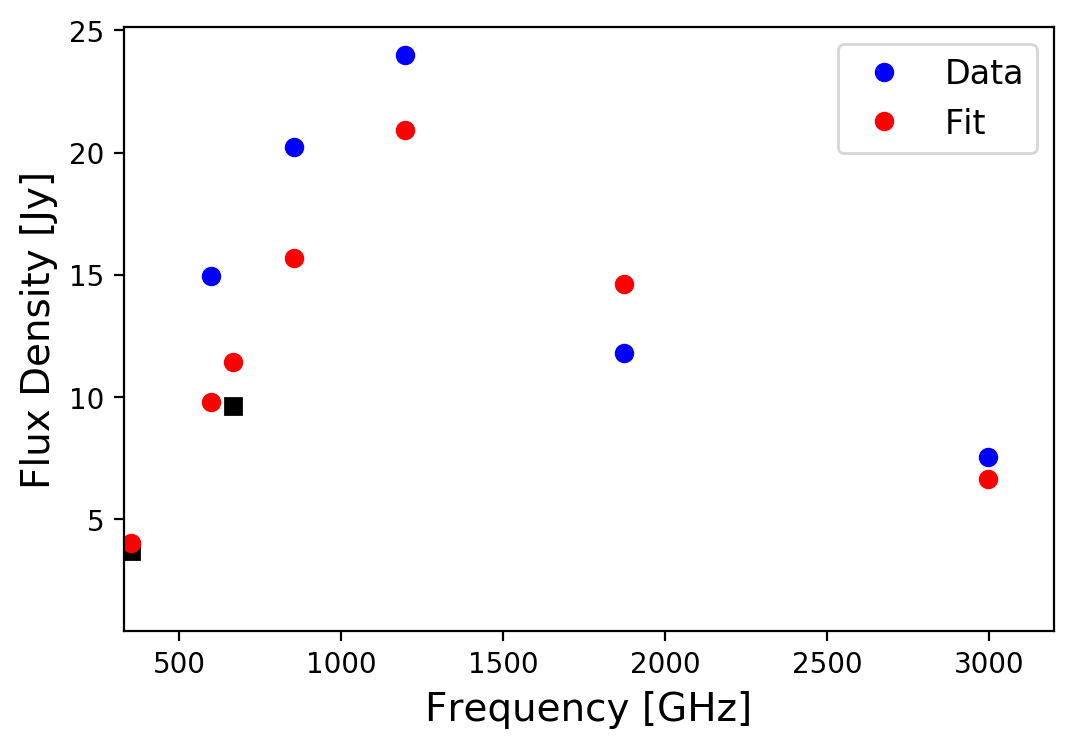

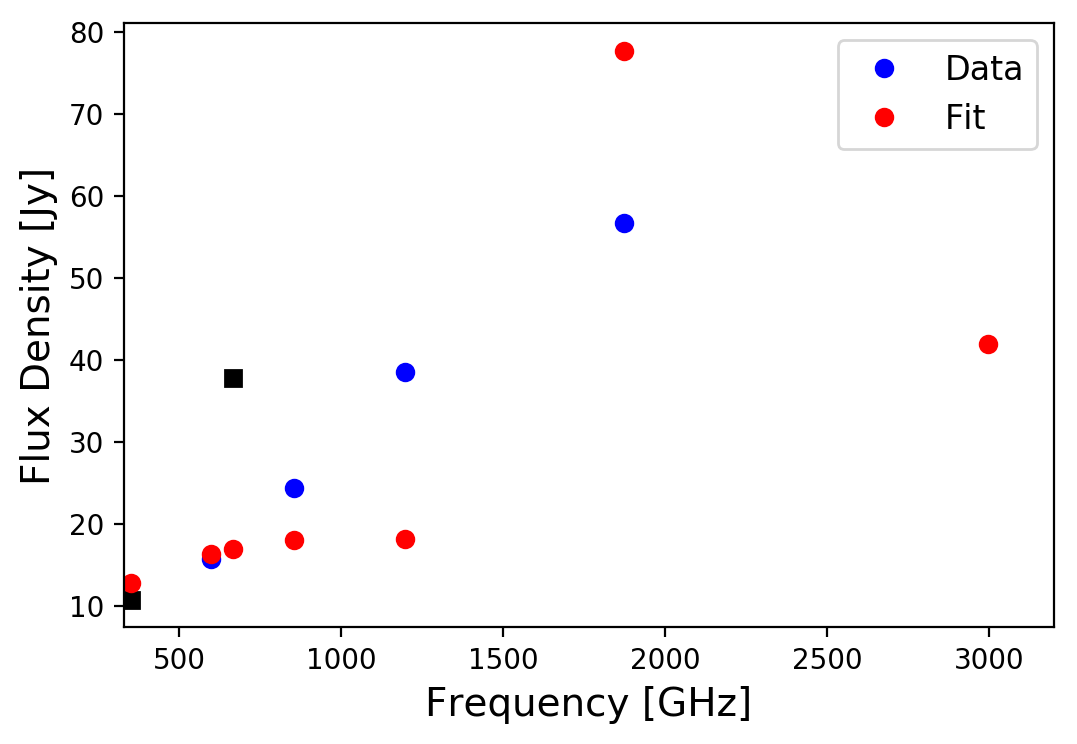

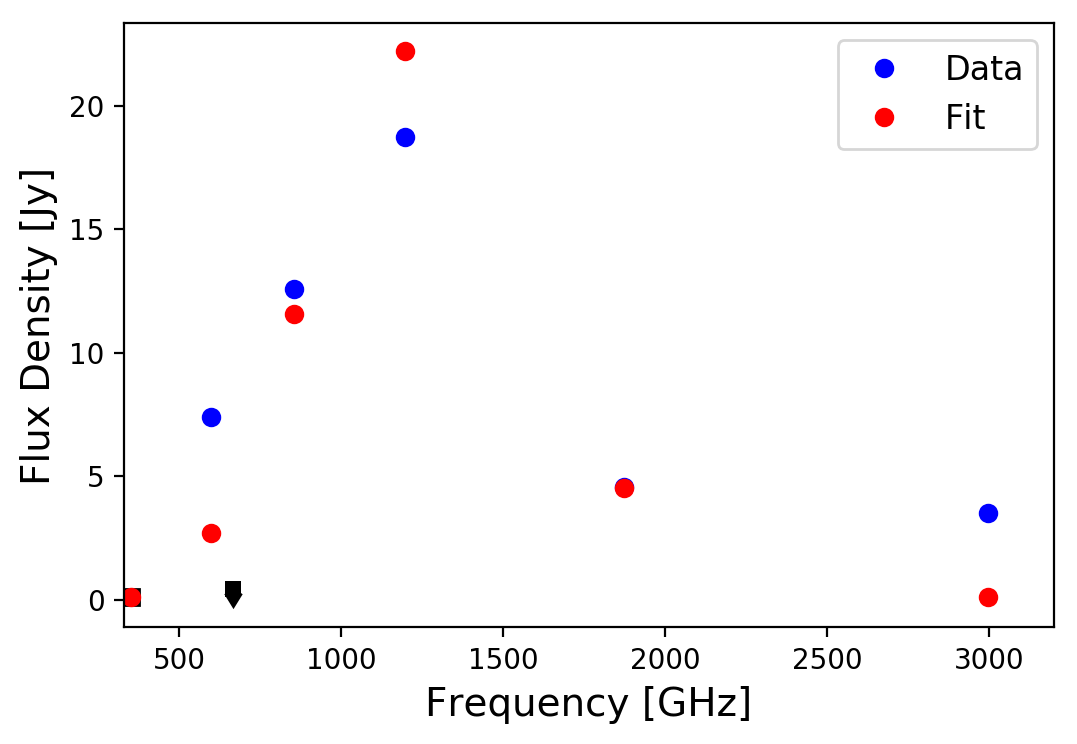

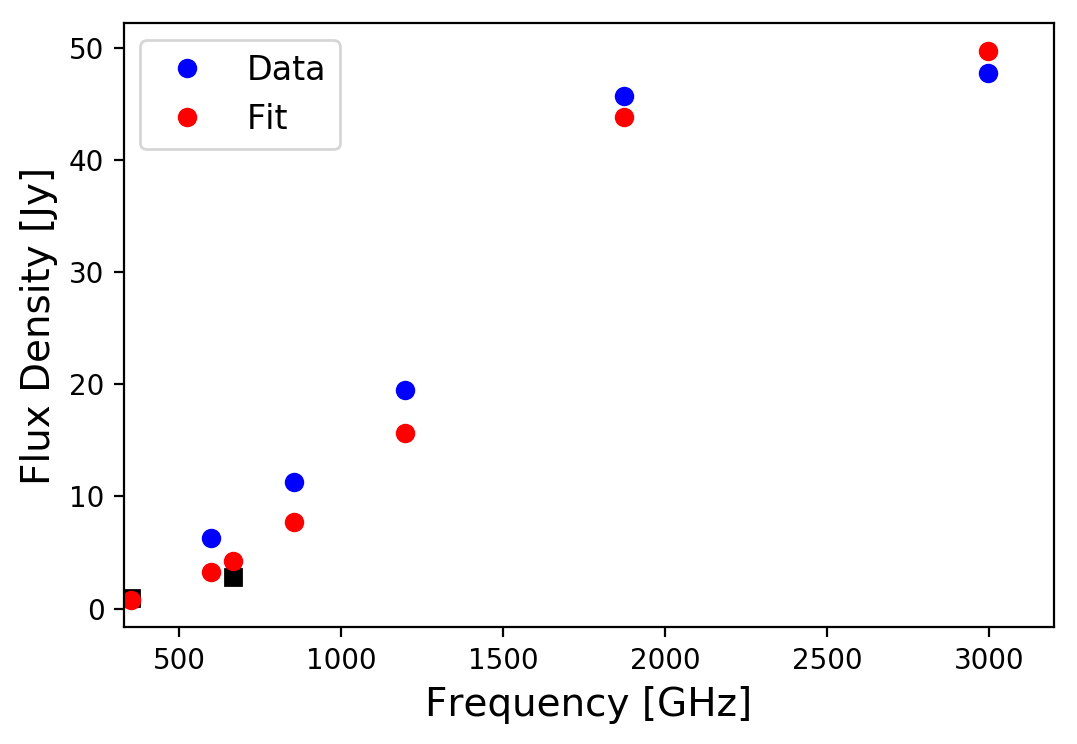

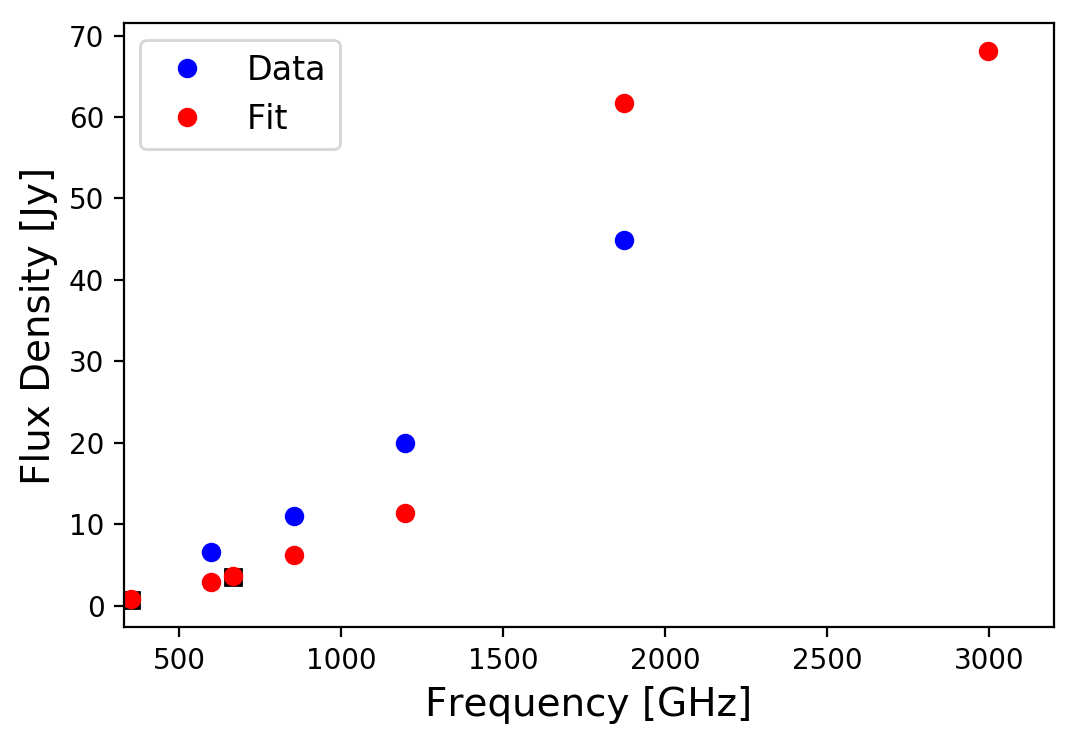

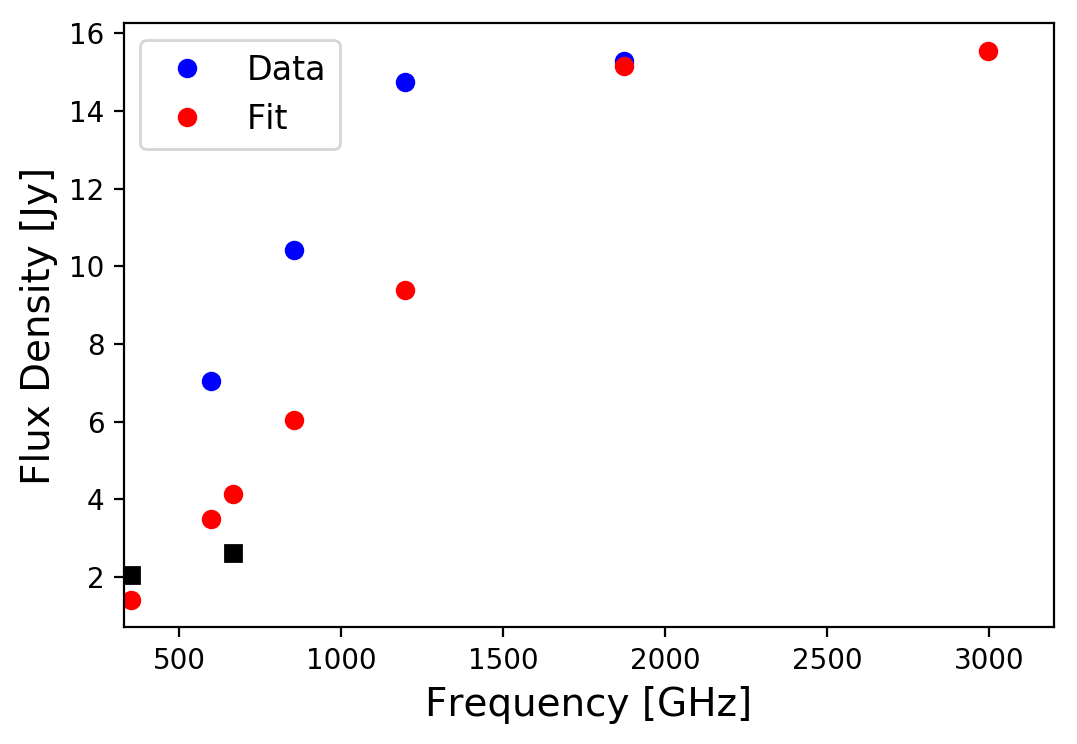

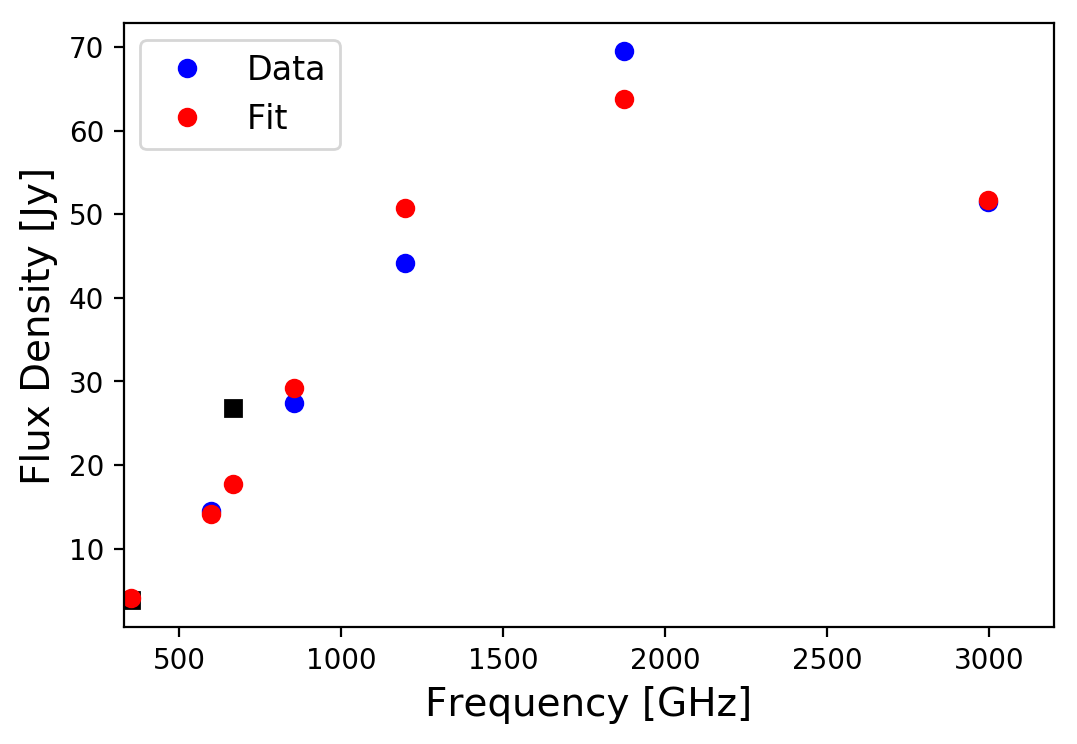

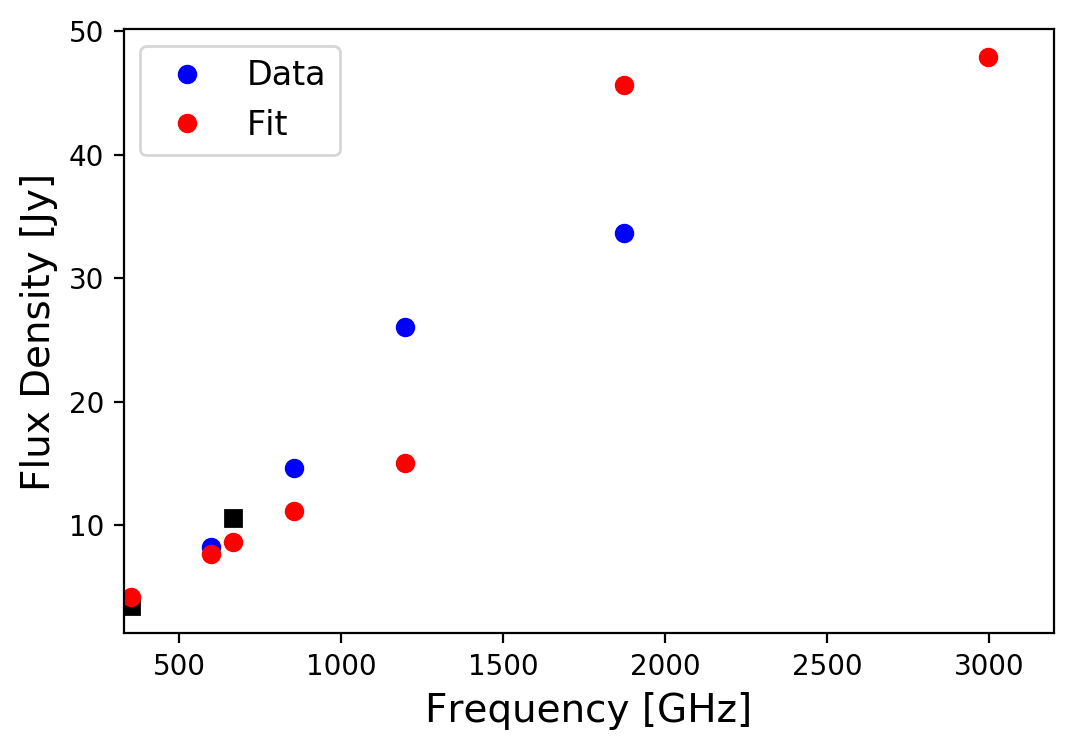

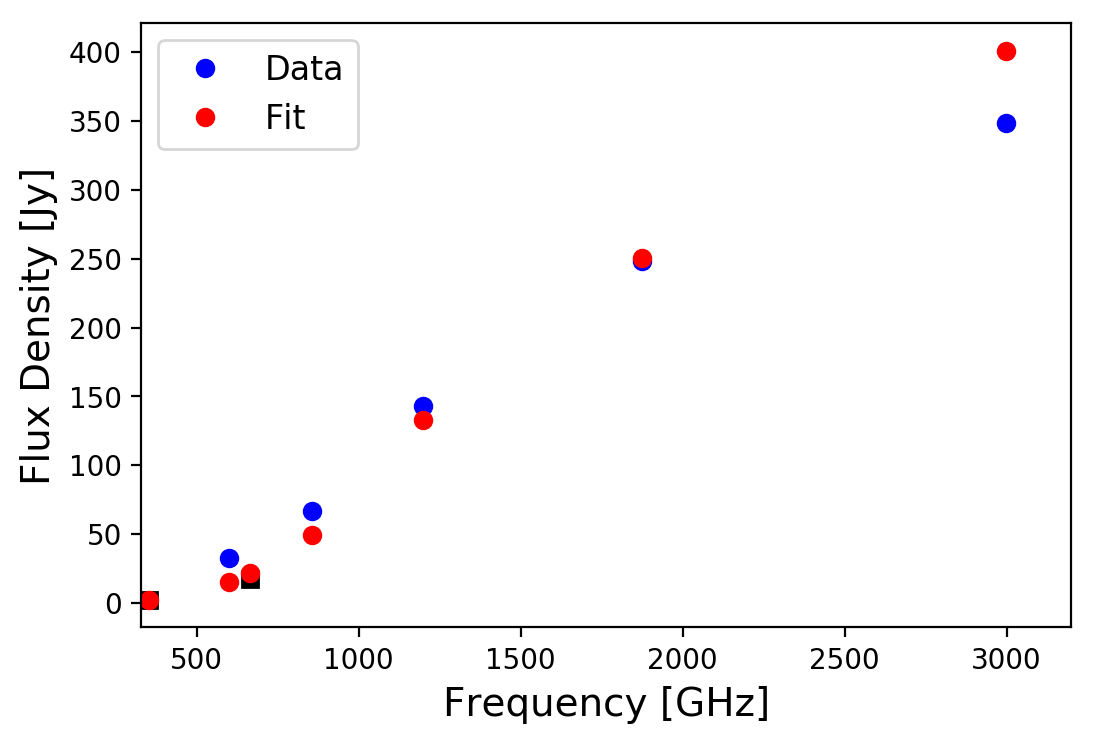

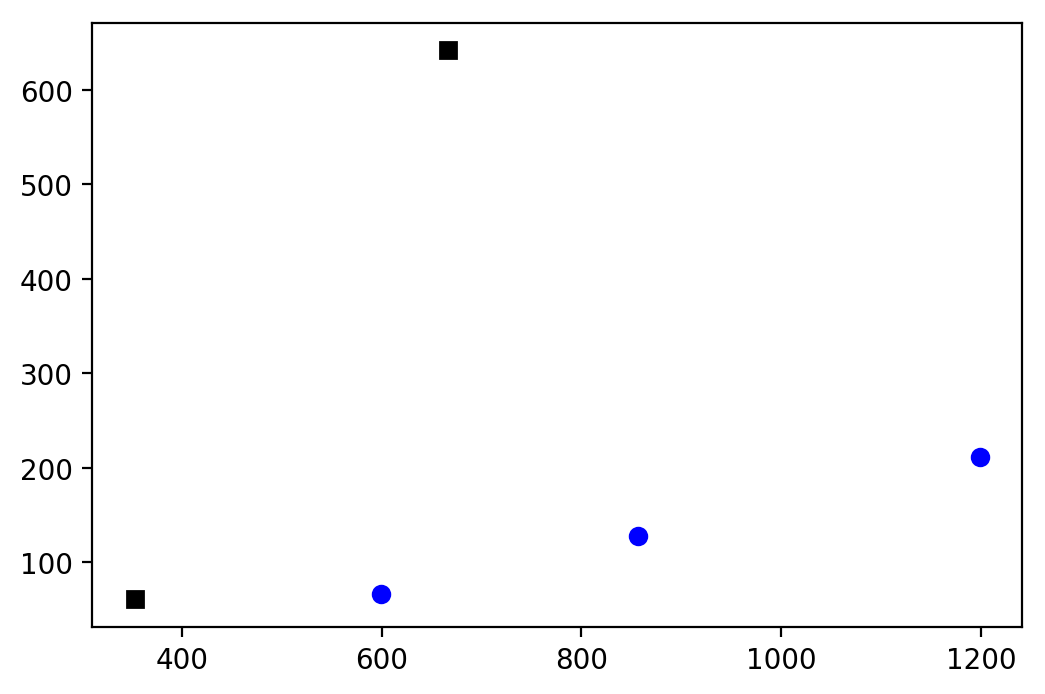

In [68]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import glob
import numpy as np
import astropy.constants as const
from fuzzywuzzy import fuzz, process
c = const.c.cgs.value

# getting SCUBA data
scuba = ascii.read('/Volumes/SD-Mac/Dropbox/real_cops-spire/SCUBA measurements of cops sources.txt',
                   fill_values=[('na', '0', 'F450(Jy)', 'F850(Jy)')])

foo = open('/Volumes/SD-Mac/research/cops-spire/greybbfit/results_photometry.txt', 'w')
foo.write('{:<10s}  {:<14s}  {:<14s}  {:<14s}  {:<14s}\n'.format('Object', 'Tdust', 'unc_Tdust', 'beta', 'unc_beta'))

for obj in obj_list:
    
#     if obj != 'L1014': continue
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    if not os.path.exists(archive_dir+obj+'/spire/data/'+obj+'_spire_phot.txt'):
        continue
    phot_spire = ascii.read(archive_dir+obj+'/spire/data/'+obj+'_spire_phot.txt', data_start=4)
    if os.path.exists(archive_dir+obj+'/pacs/data/'+obj+'_pacs_phot.txt'):
        phot_pacs = ascii.read(archive_dir+obj+'/pacs/data/'+obj+'_pacs_phot.txt', data_start=4)
    
        total_phot = {'Wavelength(um)':np.array([70,100,160,250,350,500]),
                      'Flux_Density(Jy)':np.zeros(6),
                      'unc':np.zeros(6)}
    else:
        total_phot = {'Wavelength(um)':np.array([250,350,500]),
                      'Flux_Density(Jy)':np.zeros(3),
                      'unc':np.zeros(3)}
    
    for i, w in enumerate(total_phot['Wavelength(um)']):
        if w < 200:
            phot_dum = np.nanmean(phot_pacs['flux(Jy)'][phot_pacs['wavelength(um)'] == w])
            unc_dum = np.nansum((phot_pacs['uncertainty(Jy)'][phot_pacs['wavelength(um)'] == w])**2)**0.5
        else:
            phot_dum = np.nanmean(phot_spire['flux(Jy)'][phot_spire['wavelength(um)'] == w])
            unc_dum = np.nansum((phot_spire['uncertainty(Jy)'][phot_spire['wavelength(um)'] == w])**2)**0.5
            
        total_phot['Flux_Density(Jy)'][total_phot['Wavelength(um)'] == w] = phot_dum
        total_phot['unc'][total_phot['Wavelength(um)'] == w] = unc_dum
    
    
    fitted_size = ascii.read(glob.glob(archive_dir+obj+'/spire/data/*meta*')[0], data_start=4)['size'].data[0]
    data, = ax.plot(c/total_phot['Wavelength(um)']*1e4/1e9, total_phot['Flux_Density(Jy)'], 'bo')

    # insert SCUBA data if applicable
    # first fuzzy match the source name
    match = process.extractOne(obj, scuba['Source'])
    if match[1] < 90:
        print(match)
    else:
        # check if there is data for the object
        # 450 um
        if (scuba['F450(Jy)'][scuba['Source'] == match[0]].mask == False):
            if (scuba['F450(Jy)'][scuba['Source'] == match[0]] >= 0):
                total_phot['Wavelength(um)'] = np.append(total_phot['Wavelength(um)'], [450.0])
                total_phot['Flux_Density(Jy)'] = np.append(total_phot['Flux_Density(Jy)'],
                                                           [scuba['F450(Jy)'][scuba['Source'] == match[0]].data])
                total_phot['unc'] = np.append(total_phot['unc'], [np.nan])
                ax.plot(c/450*1e4/1e9, total_phot['Flux_Density(Jy)'][total_phot['Wavelength(um)'] == 450], 'ks')
            else:
                ax.errorbar(c/450*1e4/1e9, abs(scuba['F450(Jy)'][scuba['Source'] == match[0]]),
                            yerr=-scuba['F450(Jy)'][scuba['Source'] == match[0]]/3,
                            uplims=True, fmt='s', mfc='k', markeredgewidth=1,
                            color='k', mec='None')
            
        # 850 um
        if (scuba['F850(Jy)'][scuba['Source'] == match[0]].mask == False):
            if (scuba['F850(Jy)'][scuba['Source'] == match[0]] >= 0):
                total_phot['Wavelength(um)'] = np.append(total_phot['Wavelength(um)'], [850.0])
                total_phot['Flux_Density(Jy)'] = np.append(total_phot['Flux_Density(Jy)'],
                                                           [scuba['F850(Jy)'][scuba['Source'] == match[0]].data])
                total_phot['unc'] = np.append(total_phot['unc'], [np.nan])
                ax.plot(c/850*1e4/1e9, total_phot['Flux_Density(Jy)'][total_phot['Wavelength(um)'] == 850], 'ks')
            else:
                ax.errorbar(c/850*1e4/1e9, abs(scuba['F850(Jy)'][scuba['Source'] == match[0]]),
                                yerr=-scuba['F850(Jy)'][scuba['Source'] == match[0]]/3,
                                uplims=True, fmt='s', mfc='k', markeredgewidth=1,
                                color='k', mec='None')
                
    popt, pcov, bbfunc = modbb_fitter(total_phot, fitted_size, verbose=False)

    foo.write('{:<10s}  {:<14e}  {:<14e}  {:<14e}  {:<14e}\n'.format(obj, popt[0], pcov[0,0]**0.5, popt[1], pcov[1,1]**0.5))


    fit, = ax.plot(c/total_phot['Wavelength(um)']*1e4/1e9, bbfunc(c/total_phot['Wavelength(um)']*1e4, *popt), 'ro')
    
    ax.legend([data, fit], ['Data', 'Fit'], loc='best', fontsize=12)
#     ax.set_xlabel('Wavelength [$\mu$m]', fontsize=18)
    ax.set_xlabel('Frequency [GHz]', fontsize=14)
    ax.set_ylabel('Flux Density [Jy]', fontsize=14)
    ax.set_xlim([330,3200])
    
    fig.savefig('/Volumes/SD-Mac/research/cops-spire/greybbfit/'+obj+'_fitting_phot.pdf', format='pdf', dpi=300, bbox_inches='tight')
    
foo.close()

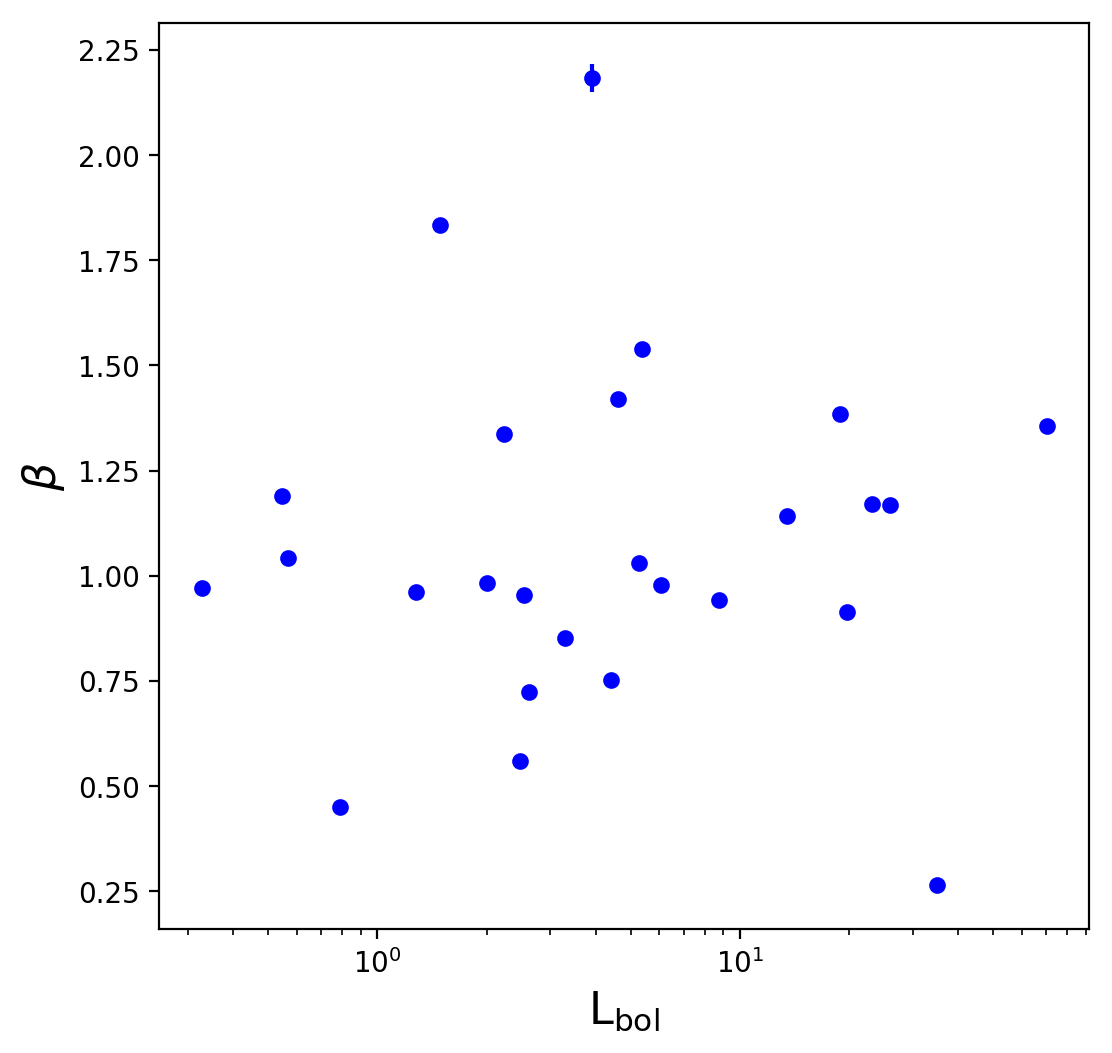

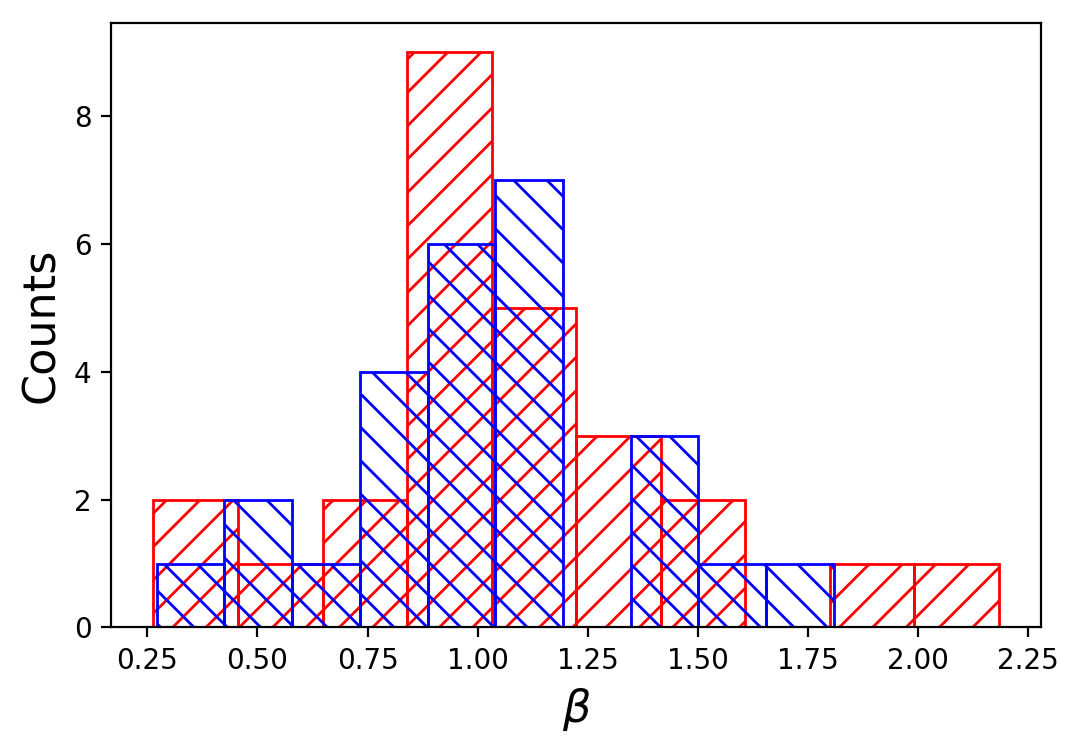

In [26]:
import matplotlib.pyplot as plt
data = ascii.read('/Volumes/SD-Mac/research/cops-spire/greybbfit/results.txt')
data_old = ascii.read('/Volumes/SD-Mac/Dropbox/real_cops-spire/greybbfit/results.txt')

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

for l in l_bol_list:
    ax.errorbar(l, data['beta'][data['Object'] == obj_list[l_bol_list.index(l)]],
                yerr=data['unc_beta'][data['Object'] == obj_list[l_bol_list.index(l)]],
                marker='o', markersize=5, color='b')
ax.set_xscale('log')
ax.set_xlabel(r'L$_{\rm bol}$', fontsize=16)
ax.set_ylabel(r'$\beta$', fontsize=16)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(data['beta'], facecolor='None', edgecolor='r', hatch='//')
ax.hist(data_old['beta'], facecolor='None', edgecolor='b', hatch='\\\\')
ax.set_xlabel(r'$\beta$', fontsize=16)
ax.set_ylabel('Counts', fontsize=16)
